In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
import tensorflow

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Flatten, Input, Conv2D, LSTM, GRU, BatchNormalization, MaxPooling2D, Reshape
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
from numpy.random import seed
seed(13)
tensorflow.random.set_seed(2)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive


drive.mount('/content/gdrive')
current_path = os.path.join(os.getcwd(), 'gdrive/MyDrive')
dataset_path = os.path.join(current_path,"speech_commands_v0_02_dataset")
path_save_downsampled = os.path.join(current_path, "speech_commands_data/downsampled_dataset")
path_save_small = os.path.join(current_path, "speech_commands_data/small_dataset")


path_save_small_mfcc = os.path.join(path_save_small, 'mfcc')


Mounted at /content/gdrive


In [ ]:
os.listdir(path_save_small_mfcc)

['x_train_small_mfcc_0.npy',
 'x_val_small_mfcc_0.npy',
 'x_test_small_mfcc_0.npy',
 'x_train_small_mfcc_1.npy',
 'x_val_small_mfcc_1.npy',
 'x_test_small_mfcc_1.npy']

In [ ]:
def load_object(path_to_file):
  with open(path_to_file, "rb") as input_file:
    object = pickle.load(input_file)
  return object

def save_with_pickle(name_file, data, path_to_safe):
  with open(os.path.join(path_to_safe, name_file), "wb") as file:
      pickle.dump(data, file)

# Creation of classes

In [ ]:
small_train_label = load_object(os.path.join(path_save_small, 'cleaned_label_train_small.pickle'))
small_val_label = load_object(os.path.join(path_save_small, 'cleaned_label_val_small.pickle'))
small_test_label = load_object(os.path.join(path_save_small, 'cleaned_label_test_small.pickle'))

In [ ]:
commands_unkown_word = {"bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"}
commands = np.unique(small_train_label)

In [ ]:

def assign_num_to_command(commands, commands_unkown_word):
  """Assigns a number to each command. Commands belonging to commands_unkown_word
  will be assigned the same number (the last one).

  :param commands: List of all commands, including the ones that belong to
  command_unkown_word.
  :param commands_unkown_word: List of commands that belong to unknown word class.
  :return: Dictionary that maps each class with a number.
  """
  commands_numerical = {}

  c = 0
  for command in commands:
    if command not in commands_unkown_word:
      commands_numerical[str(command)] = c
      c += 1
    else:
      commands_numerical[str(command)] = len(commands) - len(commands_unkown_word)
  return(commands_numerical)

def create_label_numerical_array(labels):
  """Returns an array that has replaced the classes in "labels" by their
  assigned numbers.
  :param labels: List of labels (classes) of instances.
  :return: Array with the labels replaced by the corresponding number.
  """
  commands_numerical = assign_num_to_command(commands, commands_unkown_word)

  y_array = np.array(labels, dtype=object)
  for command in commands:
    y_array = np.where(y_array == command, commands_numerical[str(command)], y_array)
  return y_array


In [ ]:
label_train = create_label_numerical_array(small_train_label)

n_classes = len(set(label_train))

# One-hot encoding
y_train = to_categorical(label_train, num_classes=n_classes)
y_val = to_categorical(create_label_numerical_array(small_val_label), num_classes=n_classes)
y_test = to_categorical(create_label_numerical_array(small_test_label), num_classes=n_classes)


In [ ]:
classes = set(commands) - set(commands_unkown_word)
classes = np.unique(list(classes))
classes = np.append(classes, 'unkown_word')

# Load data

In [ ]:
small_train_data = np.load(os.path.join(path_save_small_mfcc, 'x_train_small_mfcc_0.npy'))
small_val_data = np.load(os.path.join(path_save_small_mfcc, 'x_val_small_mfcc_0.npy'))
small_test_data = np.load(os.path.join(path_save_small_mfcc, 'x_test_small_mfcc_0.npy'))


In [ ]:
small_train_data.shape

(13050, 25, 32)

In [ ]:
# Normalize data
train_shape = np.array(small_train_data).shape

x_train_flattened = small_train_data.flatten()

scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train_flattened.reshape(-1, 1))

x_train = x_train_normalized.reshape(train_shape)

def normalize_data(data, scaler):
  shape = data.shape
  data_flattened = data.flatten()
  data_normalized = scaler.transform(data_flattened.reshape(-1,1))
  return data_normalized.reshape(shape)


In [ ]:
x_train.shape

(13050, 25, 32)

In [ ]:
x_val = normalize_data(small_val_data, scaler)
x_test = normalize_data(small_test_data, scaler)

In [ ]:

input_shape = (25, 32, 1)

In [ ]:
input_shape

(25, 32, 1)

# Functions for evaluating model

In [ ]:
class MetricsInfoShower:
  """Class for showing reports and graphics regarding training and test
  evaluation."""

  def __init__(self, model, h_model, x, y_true, batch_size, classes) -> None:
    self.model = model
    self.h_model = h_model
    self.last_epoch = len(self.h_model.history['loss'])
    self.batch_size = batch_size
    self.y_true = np.argmax(y_test, axis=1)
    self.y_pred = self._get_y_pred(x)
    self.classes = classes



  def _get_y_pred(self, x):
    y_pred = self.model.predict(x, batch_size=self.batch_size)
    return y_pred.argmax(axis=1)

  def show_classification_report(self):
    # Evaluación del modelo
    print("[INFO]: Evaluando el modelo...")

    # Report
    print(classification_report(self.y_true, self.y_pred, target_names=self.classes))

  def show_confusion_matrix(self):
    # Calcula la matriz de confusión
    cm = confusion_matrix(self.y_true, self.y_pred, normalize='pred')

    # Crea un gráfico de matriz de confusión utilizando seaborn
    plt.figure(figsize = (16, 16))
    ax = sns.heatmap(cm, annot=True, cmap="PuBu", fmt=".2f", xticklabels=self.classes, yticklabels=classes, vmin = 0.1 )

    # Añade etiquetas y título
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    plt.title("Matriz de Confusión")

    plt.show()

  def show_training_loss(self):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["loss"], label="train_loss")
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

  def show_training_accuracy(self):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

  def show_all(self):
    self.show_training_loss()
    self.show_training_accuracy()
    self.show_classification_report()
    self.show_confusion_matrix()

### Experimento_A_cnn_mfcc_0_00

In [ ]:
exp_a_cnn_mfcc_0_00 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_mfcc_0_00.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x, verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_0_00.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_0_00.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 64
h_exp_a_cnn_mfcc_0_00 = exp_a_cnn_mfcc_0_00.fit(x_train, y_train,
                                              batch_size=batch_size, epochs=50,
                                              validation_data=(x_val, y_val),
                                              callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1651 - loss: 2.8972
Epoch 1: val_loss improved from inf to 1.98027, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.1657 - loss: 2.8952 - val_accuracy: 0.4106 - val_loss: 1.9803 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/50
200/204 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4997 - loss: 1.7199
Epoch 2: val_loss improved from 1.98027 to 1.55076, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5005 - loss: 1.7171 - val_accuracy: 0.5502 - val_loss: 1.5508 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/50
199/204 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6246 - loss: 1.2772
Epoch 3: val_loss improved from 1.55076 to 1.30822, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6250 - loss: 1.2755 - val_accuracy: 0.6083 - val_loss: 1.3082 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/50
201/204 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6969 - loss: 1.0287
Epoch 4: val_loss improved from 1.30822 to 1.19136, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6971 - loss: 1.0281 - val_accuracy: 0.6468 - val_loss: 1.1914 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/50
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7389 - loss: 0.8715
Epoch 5: val_loss improved from 1.19136 to 1.12459, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7390 - loss: 0.8713 - val_accuracy: 0.6657 - val_loss: 1.1246 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7749 - loss: 0.7569
Epoch 6: val_loss improved from 1.12459 to 1.09583, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7749 - loss: 0.7568 - val_accuracy: 0.6823 - val_loss: 1.0958 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/50
193/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7995 - loss: 0.6716
Epoch 7: val_loss improved from 1.09583 to 1.08861, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7999 - loss: 0.6703 - val_accuracy: 0.6717 - val_loss: 1.0886 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/50
201/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8197 - loss: 0.5972
Epoch 8: val_loss improved from 1.08861 to 1.07591, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8198 - loss: 0.5968 - val_accuracy: 0.6853 - val_loss: 1.0759 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8389 - loss: 0.5348
Epoch 9: val_loss did not improve from 1.07591
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8389 - loss: 0.5347 - val_accuracy: 0.6921 - val_loss: 1.1013 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/50
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8536 - loss: 0.4832
Epoch 10: val_loss did not improve from 1.07591
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8537 - loss: 0.4830 - val_accuracy: 0.6966 - val_loss: 1.1270 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/50
202/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

In [ ]:
exp_a_cnn_mfcc_0_00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 23, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 825,488 (3.15 MB)

 Trainable params: 275,162 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 550,326 (2.10 MB)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


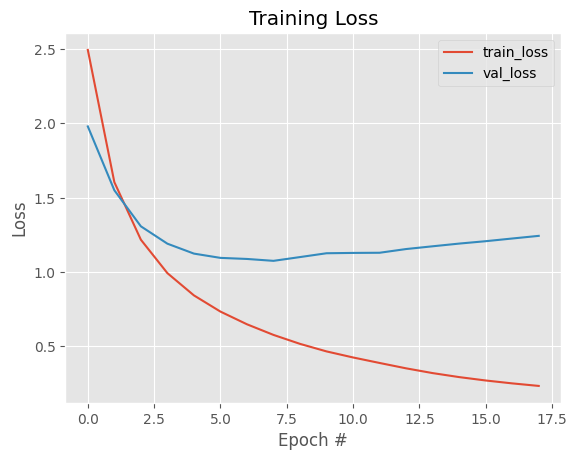

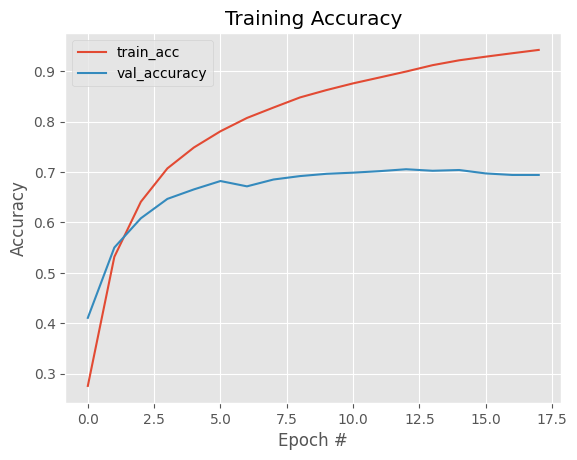

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.72      0.69      0.70        62
        down       0.64      0.58      0.61        62
       eight       0.71      0.87      0.78        62
        five       0.62      0.61      0.62        62
      follow       0.65      0.58      0.62        62
     forward       0.70      0.56      0.62        62
        four       0.73      0.60      0.65        62
          go       0.55      0.74      0.63        62
       learn       0.69      0.60      0.64        62
        left       0.77      0.76      0.76        62
        nine       0.74      0.82      0.78        62
          no       0.69      0.65      0.67        62
         off       0.70      0.76      0.73        62
          on       0.61      0.68      0.64        62
         one       0.84      0.79      0.82        62
       right       0.85      0.85      0.85        62
       seven       0.81      0.82      0.82       

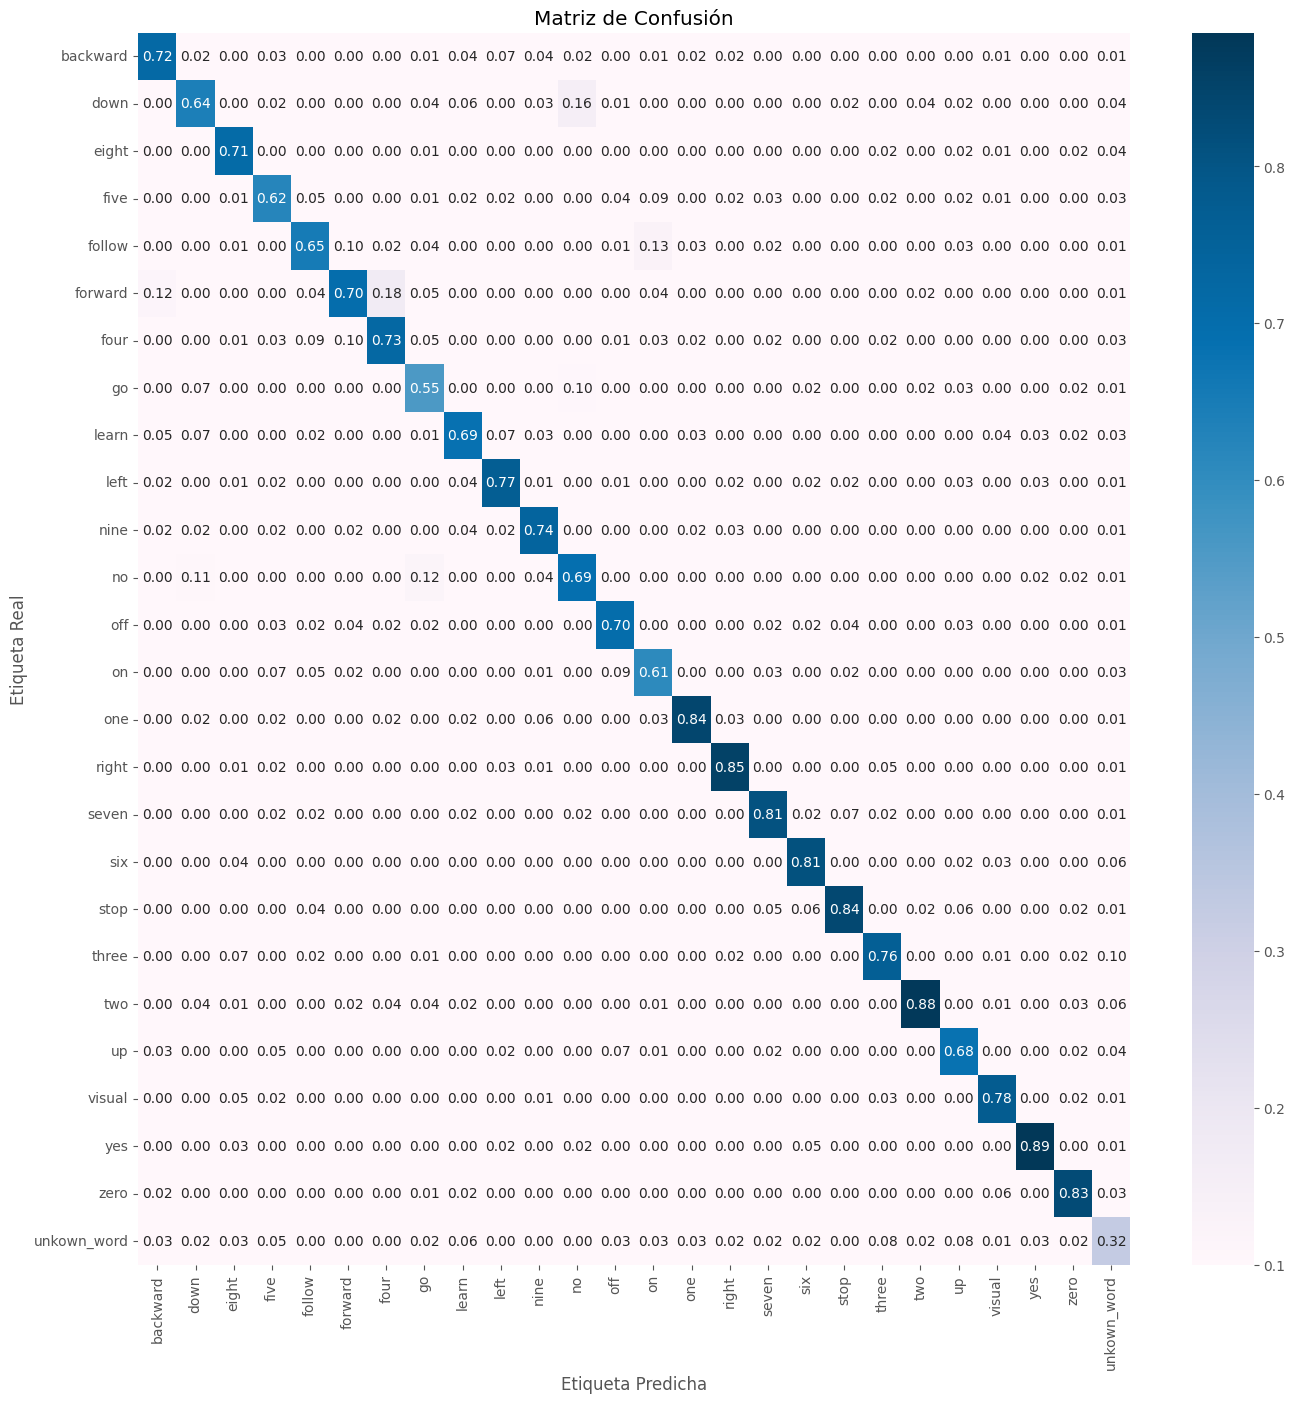

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_0_00, h_exp_a_cnn_mfcc_0_00, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_mfcc_0_01

In [ ]:
exp_a_cnn_mfcc_0_01 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_mfcc_0_01.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_0_01.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_0_01.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_mfcc_0_01 = exp_a_cnn_mfcc_0_01.fit(x_train, y_train,
                                              batch_size=batch_size, epochs=90,
                                              validation_data=(x_val, y_val),
                                              callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2722 - loss: 2.5744
Epoch 1: val_loss improved from inf to 2.22753, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.2726 - loss: 2.5730 - val_accuracy: 0.3774 - val_loss: 2.2275 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6834 - loss: 1.0390
Epoch 2: val_loss improved from 2.22753 to 1.12634, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6837 - loss: 1.0377 - val_accuracy: 0.6634 - val_loss: 1.1263 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8001 - loss: 0.6527
Epoch 3: val_loss did not improve from 1.12634
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8006 - loss: 0.6509 - val_accuracy: 0.6694 - val_loss: 1.1410 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8662 - loss: 0.4360
Epoch 4: val_loss improved from 1.12634 to 1.06380, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8662 - loss: 0.4358 - val_accuracy: 0.7034 - val_loss: 1.0638 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9180 - loss: 0.2834
Epoch 5: val_loss improved from 1.06380 to 0.97507, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9184 - loss: 0.2822 - val_accuracy: 0.7366 - val_loss: 0.9751 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9571 - loss: 0.1691
Epoch 6: val_loss did not improve from 0.97507
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9574 - loss: 0.1685 - val_accuracy: 0.7494 - val_loss: 0.9824 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9789 - loss: 0.0973
Epoch 7: val_loss did not improve from 0.97507
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9790 - loss: 0.0971 - val_accuracy: 0.7683 - val_loss: 0.9802 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9908 - loss: 0

In [ ]:
exp_a_cnn_mfcc_0_01.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 23, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 23, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 9, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 9, 13, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 827,024 (3.15 MB)

 Trainable params: 275,546 (1.05 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 551,094 (2.10 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


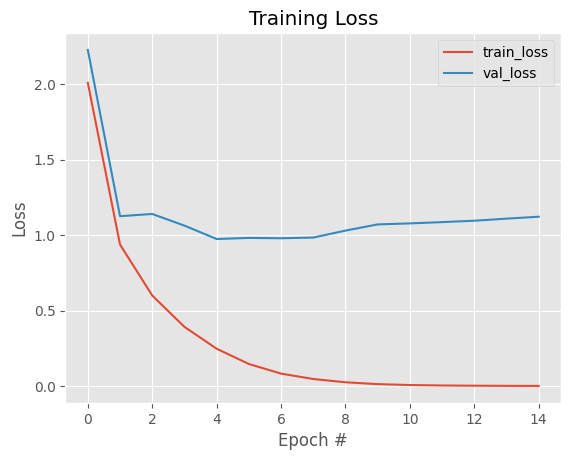

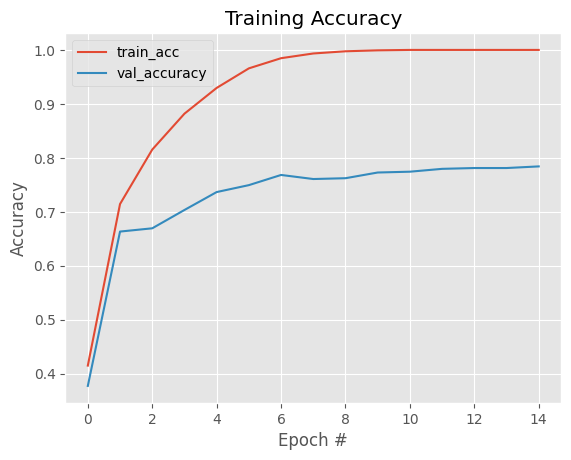

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.82      0.81      0.81        62
        down       0.77      0.66      0.71        62
       eight       0.95      0.84      0.89        62
        five       0.82      0.76      0.79        62
      follow       0.73      0.71      0.72        62
     forward       0.76      0.68      0.72        62
        four       0.75      0.71      0.73        62
          go       0.71      0.81      0.76        62
       learn       0.85      0.73      0.78        62
        left       0.70      0.77      0.73        62
        nine       0.85      0.84      0.85        62
          no       0.68      0.82      0.74        62
         off       0.89      0.77      0.83        62
          on       0.72      0.68      0.70        62
         one       0.76      0.82      0.79        62
       right       0.95      0.85      0.90        62
       seven       0.89      0.87      0.88       

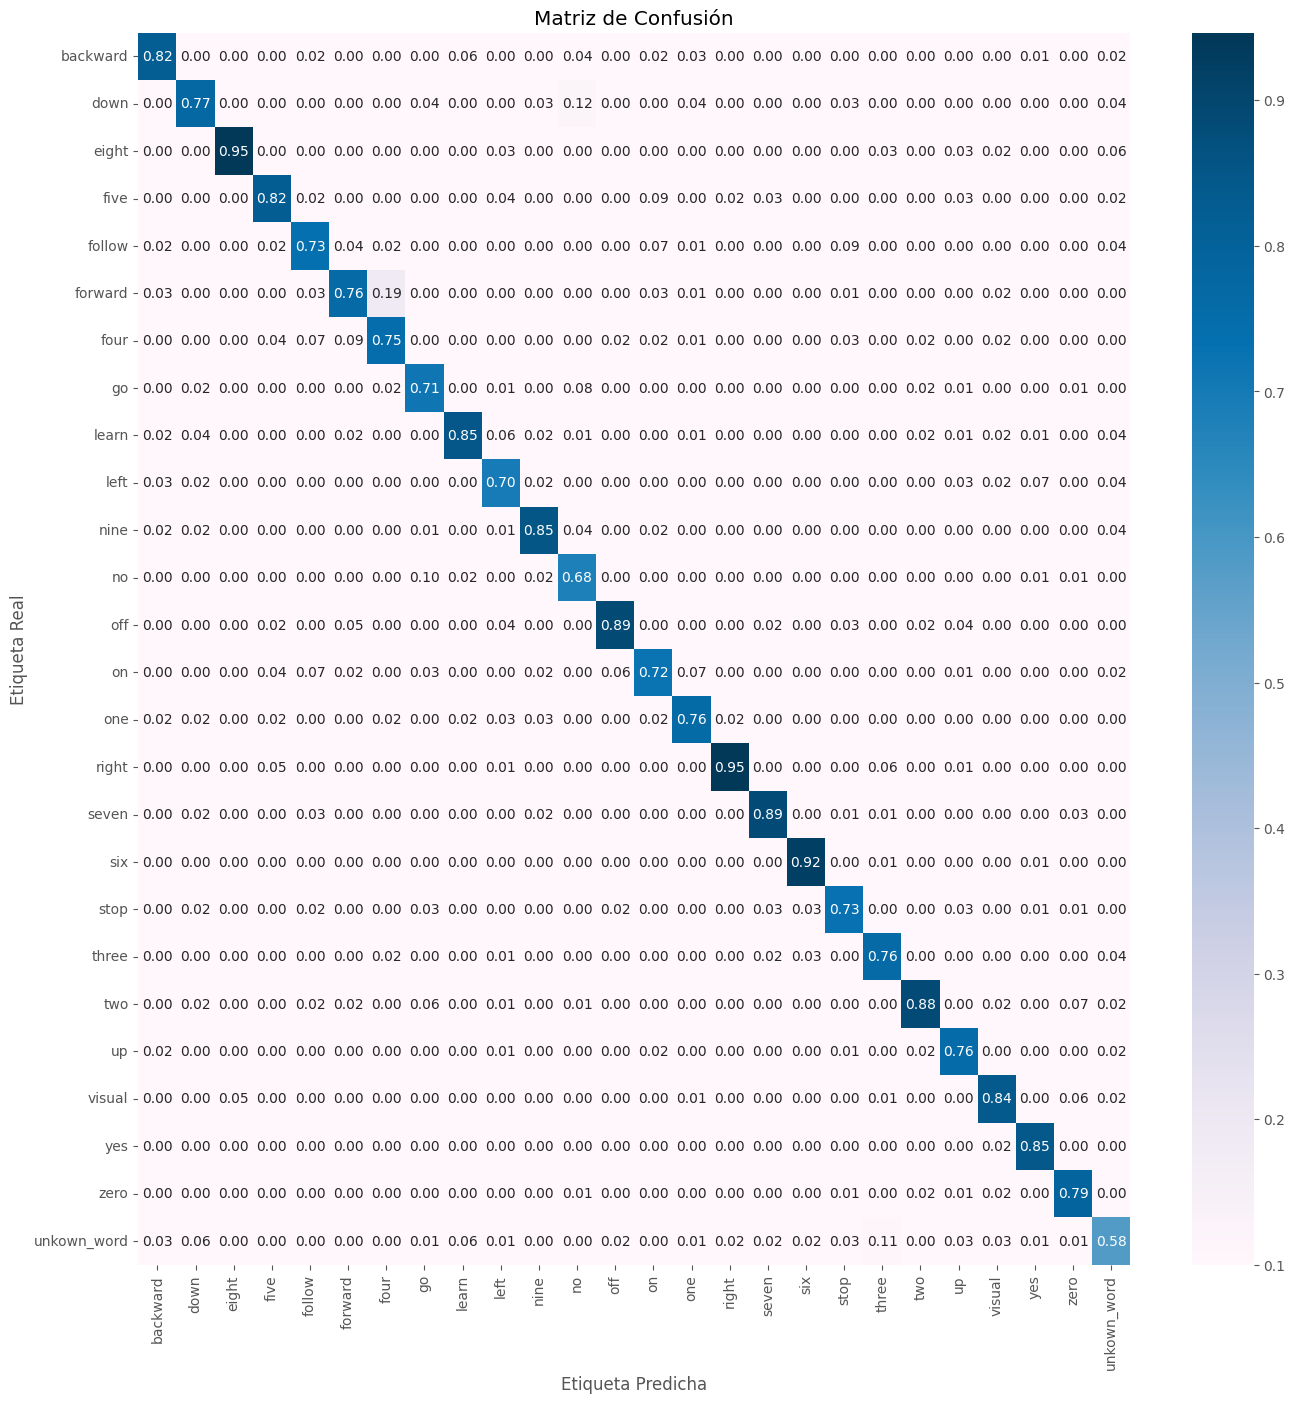

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_0_01, h_exp_a_cnn_mfcc_0_01, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_mfcc_0_02

In [ ]:
exp_a_cnn_mfcc_0_02 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Capa de salida
    Dense(n_classes, activation='softmax')])

exp_a_cnn_mfcc_0_02.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_0_02.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_0_02.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_mfcc_0_02 = exp_a_cnn_mfcc_0_02.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0613 - loss: 3.3677
Epoch 1: val_loss improved from inf to 3.01435, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.0614 - loss: 3.3672 - val_accuracy: 0.1306 - val_loss: 3.0143 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1756 - loss: 2.7514
Epoch 2: val_loss improved from 3.01435 to 2.19676, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1763 - loss: 2.7489 - val_accuracy: 0.3389 - val_loss: 2.1968 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3076 - loss: 2.2618
Epoch 3: val_loss improved from 2.19676 to 1.77898, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3081 - loss: 2.2598 - val_accuracy: 0.4642 - val_loss: 1.7790 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3963 - loss: 1.9326
Epoch 4: val_loss improved from 1.77898 to 1.43160, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3968 - loss: 1.9313 - val_accuracy: 0.5653 - val_loss: 1.4316 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4743 - loss: 1.6786
Epoch 5: val_loss improved from 1.43160 to 1.24886, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4747 - loss: 1.6774 - val_accuracy: 0.6242 - val_loss: 1.2489 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5484 - loss: 1.4241
Epoch 6: val_loss improved from 1.24886 to 1.18967, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5484 - loss: 1.4239 - val_accuracy: 0.6423 - val_loss: 1.1897 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5762 - loss: 1.3176
Epoch 7: val_loss improved from 1.18967 to 1.04726, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5763 - loss: 1.3174 - val_accuracy: 0.6906 - val_loss: 1.0473 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6129 - loss: 1.1936
Epoch 8: val_loss improved from 1.04726 to 0.94723, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6131 - loss: 1.1937 - val_accuracy: 0.7147 - val_loss: 0.9472 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6472 - loss: 1.0989
Epoch 9: val_loss improved from 0.94723 to 0.93663, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6473 - loss: 1.0987 - val_accuracy: 0.7208 - val_loss: 0.9366 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6804 - loss: 1.0104
Epoch 10: val_loss improved from 0.93663 to 0.85435, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6804 - loss: 1.0106 - val_accuracy: 0.7374 - val_loss: 0.8544 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6949 - loss: 0.9591
Epoch 11: val_loss improved from 0.85435 to 0.84373, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6949 - loss: 0.9592 - val_accuracy: 0.7381 - val_loss: 0.8437 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7132 - loss: 0.8935
Epoch 12: val_loss improved from 0.84373 to 0.81447, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7131 - loss: 0.8936 - val_accuracy: 0.7562 - val_loss: 0.8145 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7263 - loss: 0.8711
Epoch 13: val_loss did not improve from 0.81447
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7263 - loss: 0.8708 - val_accuracy: 0.7562 - val_loss: 0.8212 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7387 - loss: 0.8176
Epoch 14: val_loss improved from 0.81447 to 0.77243, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7387 - loss: 0.8176 - val_accuracy: 0.7638 - val_loss: 0.7724 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7406 - loss: 0.7941
Epoch 15: val_loss improved from 0.77243 to 0.76837, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7407 - loss: 0.7939 - val_accuracy: 0.7630 - val_loss: 0.7684 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7511 - loss: 0.7710
Epoch 16: val_loss improved from 0.76837 to 0.76673, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7511 - loss: 0.7709 - val_accuracy: 0.7668 - val_loss: 0.7667 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7574 - loss: 0.7512
Epoch 17: val_loss improved from 0.76673 to 0.74609, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7575 - loss: 0.7510 - val_accuracy: 0.7706 - val_loss: 0.7461 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7695 - loss: 0.6949
Epoch 18: val_loss improved from 0.74609 to 0.74445, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7696 - loss: 0.6950 - val_accuracy: 0.7728 - val_loss: 0.7445 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7748 - loss: 0.6784
Epoch 19: val_loss did not improve from 0.74445
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7749 - loss: 0.6784 - val_accuracy: 0.7743 - val_loss: 0.7466 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7835 - loss: 0.6746
Epoch 20: val_loss improved from 0.74445 to 0.74284, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7835 - loss: 0.6745 - val_accuracy: 0.7736 - val_loss: 0.7428 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7878 - loss: 0.6502
Epoch 21: val_loss improved from 0.74284 to 0.73779, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7878 - loss: 0.6503 - val_accuracy: 0.7774 - val_loss: 0.7378 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7928 - loss: 0.6437
Epoch 22: val_loss improved from 0.73779 to 0.73000, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7928 - loss: 0.6436 - val_accuracy: 0.7849 - val_loss: 0.7300 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8033 - loss: 0.6104
Epoch 23: val_loss improved from 0.73000 to 0.72348, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8032 - loss: 0.6106 - val_accuracy: 0.7819 - val_loss: 0.7235 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7986 - loss: 0.6177
Epoch 24: val_loss did not improve from 0.72348
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7986 - loss: 0.6176 - val_accuracy: 0.7811 - val_loss: 0.7267 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8016 - loss: 0.6110
Epoch 25: val_loss did not improve from 0.72348
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8016 - loss: 0.6110 - val_accuracy: 0.7834 - val_loss: 0.7296 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [ ]:
exp_a_cnn_mfcc_0_02.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 23, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 23, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 9, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 9, 13, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 846,800 (3.23 MB)

 Trainable params: 282,138 (1.08 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 564,278 (2.15 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


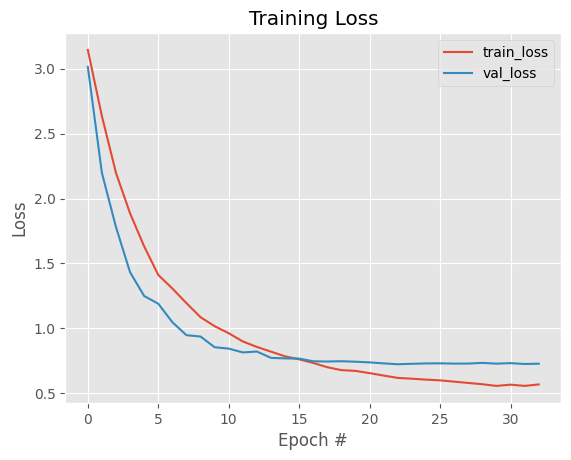

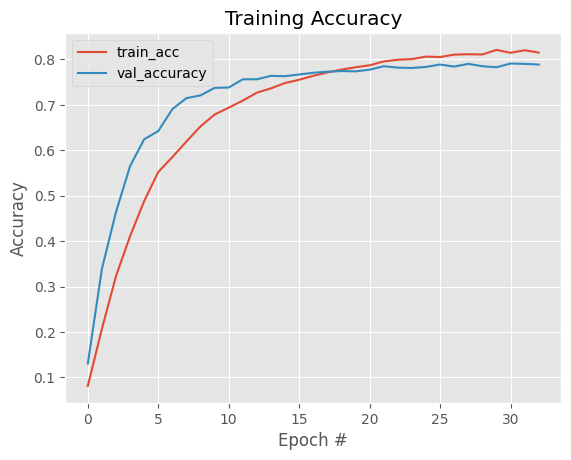

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.89      0.81      0.85        62
        down       0.79      0.74      0.77        62
       eight       0.90      0.90      0.90        62
        five       0.77      0.71      0.74        62
      follow       0.66      0.73      0.69        62
     forward       0.84      0.61      0.71        62
        four       0.74      0.77      0.76        62
          go       0.65      0.74      0.69        62
       learn       0.68      0.73      0.70        62
        left       0.85      0.84      0.85        62
        nine       0.91      0.85      0.88        62
          no       0.68      0.84      0.75        62
         off       0.88      0.81      0.84        62
          on       0.74      0.77      0.76        62
         one       0.83      0.85      0.84        62
       right       0.88      0.82      0.85        62
       seven       0.86      0.89      0.87       

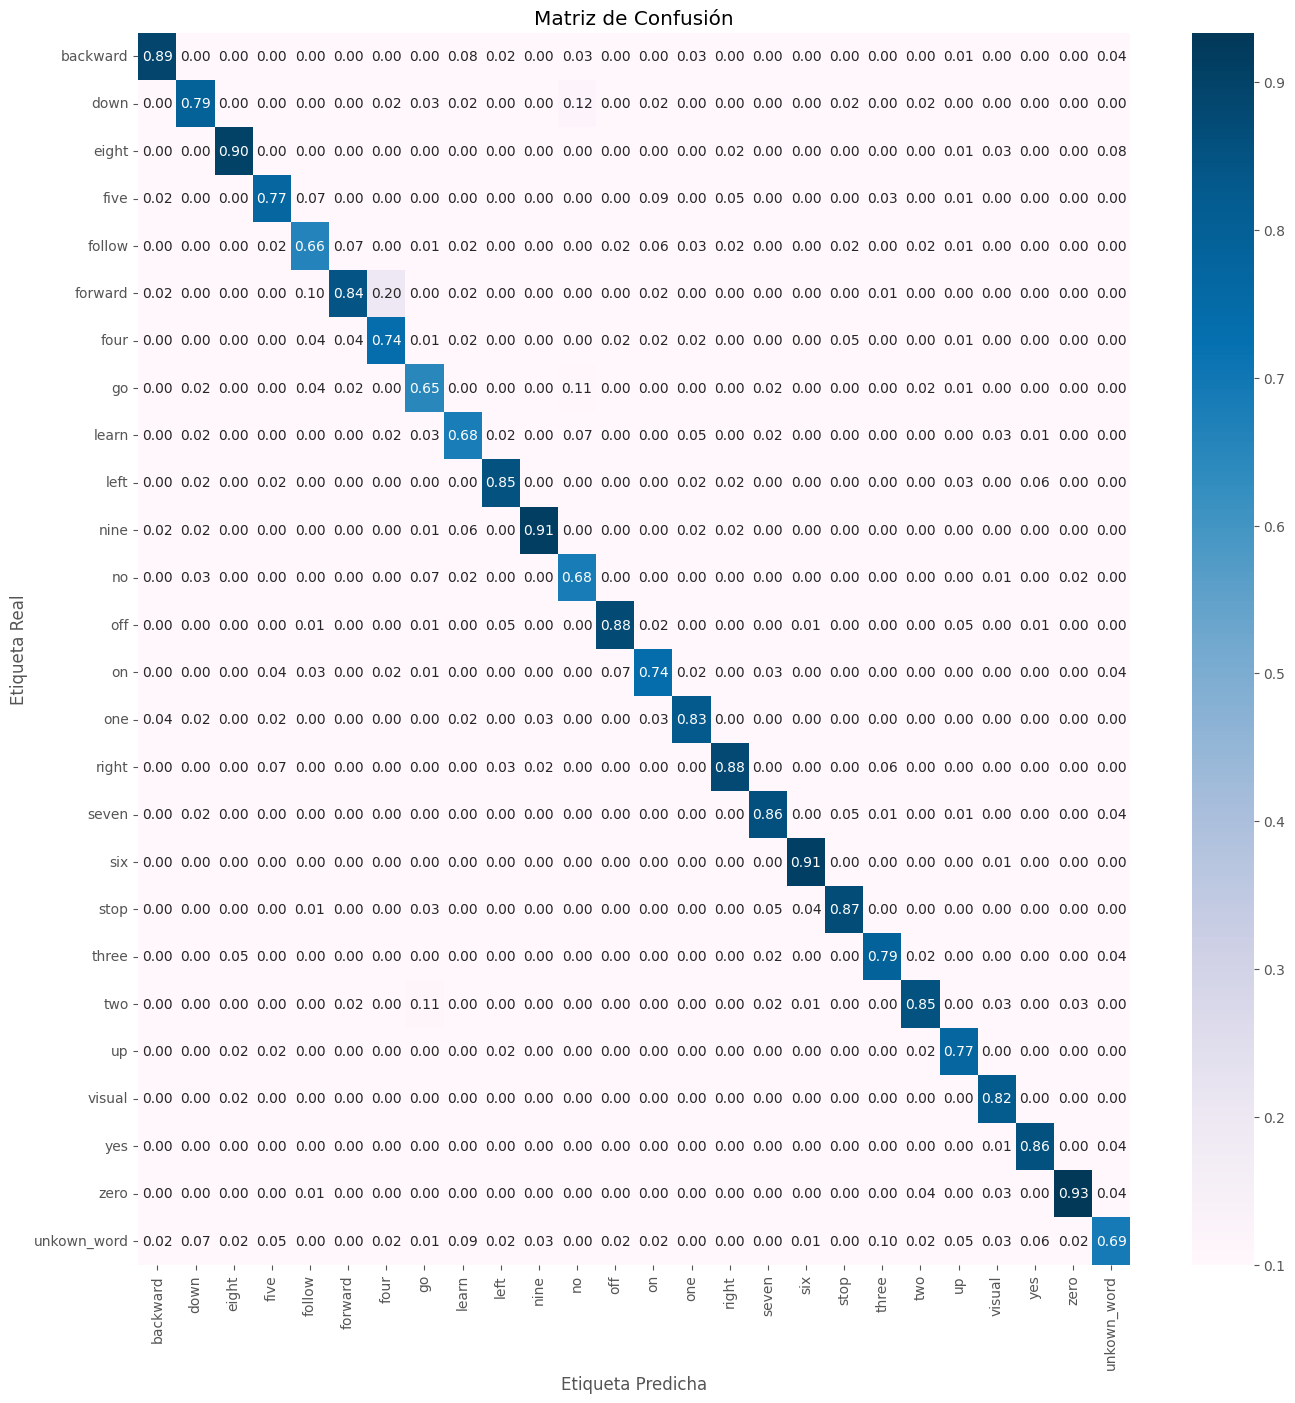

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_0_02, h_exp_a_cnn_mfcc_0_02, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_mfcc_0_03

In [ ]:
exp_a_cnn_mfcc_0_03 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_mfcc_0_03.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_0_03.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_0_03.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_mfcc_0_03 = exp_a_cnn_mfcc_0_03.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0714 - loss: 3.1340
Epoch 1: val_loss improved from inf to 2.30118, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.0716 - loss: 3.1335 - val_accuracy: 0.2770 - val_loss: 2.3012 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2928 - loss: 2.2483
Epoch 2: val_loss improved from 2.30118 to 1.75941, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2931 - loss: 2.2472 - val_accuracy: 0.4664 - val_loss: 1.7594 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4370 - loss: 1.7920
Epoch 3: val_loss improved from 1.75941 to 1.55365, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4375 - loss: 1.7903 - val_accuracy: 0.5125 - val_loss: 1.5536 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5199 - loss: 1.5263
Epoch 4: val_loss improved from 1.55365 to 1.38375, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5202 - loss: 1.5254 - val_accuracy: 0.5758 - val_loss: 1.3837 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5718 - loss: 1.3457
Epoch 5: val_loss improved from 1.38375 to 1.21008, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5721 - loss: 1.3450 - val_accuracy: 0.6181 - val_loss: 1.2101 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6209 - loss: 1.2120
Epoch 6: val_loss improved from 1.21008 to 1.14175, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6209 - loss: 1.2118 - val_accuracy: 0.6543 - val_loss: 1.1417 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6414 - loss: 1.1419
Epoch 7: val_loss improved from 1.14175 to 1.09245, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6415 - loss: 1.1414 - val_accuracy: 0.6581 - val_loss: 1.0925 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6627 - loss: 1.0607
Epoch 8: val_loss did not improve from 1.09245
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6627 - loss: 1.0608 - val_accuracy: 0.6611 - val_loss: 1.1045 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6759 - loss: 1.0335
Epoch 9: val_loss improved from 1.09245 to 1.04865, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6759 - loss: 1.0333 - val_accuracy: 0.6830 - val_loss: 1.0486 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6844 - loss: 0.9888
Epoch 10: val_loss improved from 1.04865 to 1.04647, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6845 - loss: 0.9887 - val_accuracy: 0.6883 - val_loss: 1.0465 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6961 - loss: 0.9520
Epoch 11: val_loss improved from 1.04647 to 1.00102, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6961 - loss: 0.9520 - val_accuracy: 0.7004 - val_loss: 1.0010 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7084 - loss: 0.9136
Epoch 12: val_loss improved from 1.00102 to 0.97540, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7084 - loss: 0.9136 - val_accuracy: 0.7125 - val_loss: 0.9754 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7117 - loss: 0.9023
Epoch 13: val_loss improved from 0.97540 to 0.94698, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7118 - loss: 0.9022 - val_accuracy: 0.7208 - val_loss: 0.9470 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7269 - loss: 0.8610
Epoch 14: val_loss did not improve from 0.94698
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7269 - loss: 0.8611 - val_accuracy: 0.7094 - val_loss: 0.9750 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7297 - loss: 0.8553
Epoch 15: val_loss improved from 0.94698 to 0.94034, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7298 - loss: 0.8552 - val_accuracy: 0.7192 - val_loss: 0.9403 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7409 - loss: 0.8511
Epoch 16: val_loss improved from 0.94034 to 0.92779, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7409 - loss: 0.8511 - val_accuracy: 0.7200 - val_loss: 0.9278 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7399 - loss: 0.8203
Epoch 17: val_loss improved from 0.92779 to 0.92576, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7399 - loss: 0.8203 - val_accuracy: 0.7215 - val_loss: 0.9258 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7360 - loss: 0.8196
Epoch 18: val_loss did not improve from 0.92576
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7361 - loss: 0.8195 - val_accuracy: 0.7170 - val_loss: 0.9271 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7487 - loss: 0.7984
Epoch 19: val_loss improved from 0.92576 to 0.90112, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7487 - loss: 0.7984 - val_accuracy: 0.7230 - val_loss: 0.9011 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7560 - loss: 0.7690
Epoch 20: val_loss did not improve from 0.90112
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7559 - loss: 0.7694 - val_accuracy: 0.7291 - val_loss: 0.9095 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7541 - loss: 0.7734
Epoch 21: val_loss did not improve from 0.90112
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7541 - loss: 0.7734 - val_accuracy: 0.7275 - val_loss: 0.9061 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7632 - loss: 0.7573 - val_accuracy: 0.7275 - val_loss: 0.8988 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7628 - loss: 0.7489
Epoch 25: val_loss improved from 0.89879 to 0.89617, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7628 - loss: 0.7489 - val_accuracy: 0.7328 - val_loss: 0.8962 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7631 - loss: 0.7481
Epoch 26: val_loss did not improve from 0.89617
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7631 - loss: 0.7482 - val_accuracy: 0.7306 - val_loss: 0.8965 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7611 - loss: 0.7426
Epoch 27: val_loss improved from 0.89617 to 0.88762, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7610 - loss: 0.7429 - val_accuracy: 0.7336 - val_loss: 0.8876 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7685 - loss: 0.7300
Epoch 28: val_loss did not improve from 0.88762
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7684 - loss: 0.7302 - val_accuracy: 0.7343 - val_loss: 0.8893 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7690 - loss: 0.7300
Epoch 29: val_loss did not improve from 0.88762
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7690 - loss: 0.7301 - val_accuracy: 0.7366 - val_loss: 0.8899 - learning_rate: 5.2335e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.7101286972462485e-05.
Epoch 30/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7682 - loss: 0.7278 - val_accuracy: 0.7381 - val_loss: 0.8856 - learning_rate: 3.8152e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.433683820292515e-05.
Epoch 33/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7748 - loss: 0.7168
Epoch 33: val_loss did not improve from 0.88565
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7748 - loss: 0.7168 - val_accuracy: 0.7374 - val_loss: 0.8869 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7720 - loss: 0.7182
Epoch 34: val_loss did not improve from 0.88565
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7719 - loss: 0.7182 - val_accuracy: 0.7328 - val_loss: 0.8892 - learning_rate: 3.0903e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.7812838944369376e-05.
Epoch 35/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7687 - loss: 0.7161 - val_accuracy: 0.7404 - val_loss: 0.8855 - learning_rate: 1.6423e-05

Epoch 41: LearningRateScheduler setting learning rate to 1.4780882941434608e-05.
Epoch 41/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7788 - loss: 0.7022
Epoch 41: val_loss did not improve from 0.88551
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7787 - loss: 0.7022 - val_accuracy: 0.7381 - val_loss: 0.8875 - learning_rate: 1.4781e-05

Epoch 42: LearningRateScheduler setting learning rate to 1.3302794647291146e-05.
Epoch 42/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7732 - loss: 0.7096
Epoch 42: val_loss did not improve from 0.88551
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7732 - loss: 0.7096 - val_accuracy: 0.7374 - val_loss: 0.8900 - learning_rate: 1.3303e-05

Epoch 43: LearningRateScheduler setting learning rate to 1.1972515182562033e-05.
Epoch 43/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7743 - loss: 0.7060 - val_accuracy: 0.7381 - val_loss: 0.8855 - learning_rate: 6.3627e-06

Epoch 50: LearningRateScheduler setting learning rate to 5.726416897022355e-06.
Epoch 50/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7793 - loss: 0.7062
Epoch 50: val_loss did not improve from 0.88546
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7792 - loss: 0.7061 - val_accuracy: 0.7389 - val_loss: 0.8862 - learning_rate: 5.7264e-06

Epoch 51: LearningRateScheduler setting learning rate to 5.15377520732012e-06.
Epoch 51/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7764 - loss: 0.6941
Epoch 51: val_loss did not improve from 0.88546
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7764 - loss: 0.6942 - val_accuracy: 0.7374 - val_loss: 0.8867 - learning_rate: 5.1538e-06

Epoch 52: LearningRateScheduler setting learning rate to 4.638397686588108e-06.
Epoch 52/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [ ]:
exp_a_cnn_mfcc_0_03.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 23, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 9, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 2, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 335,408 (1.28 MB)

 Trainable params: 111,802 (436.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 223,606 (873.46 KB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


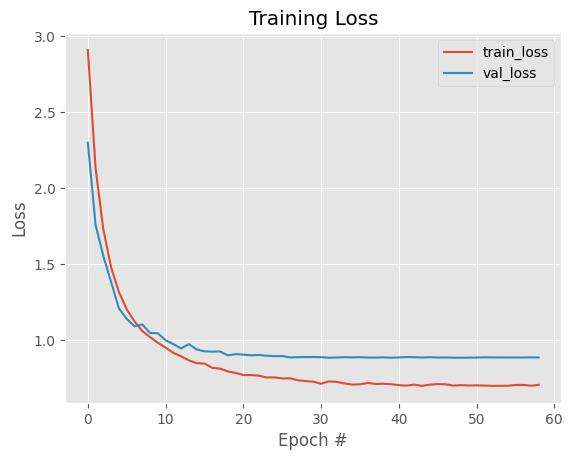

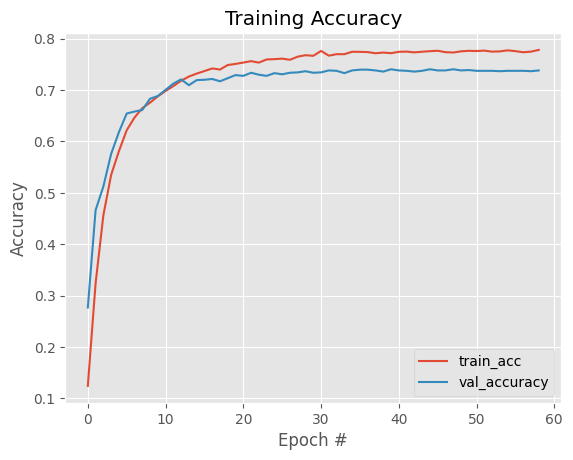

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.84      0.82      0.83        62
        down       0.74      0.63      0.68        62
       eight       0.82      0.85      0.83        62
        five       0.76      0.77      0.77        62
      follow       0.55      0.68      0.60        62
     forward       0.67      0.61      0.64        62
        four       0.75      0.69      0.72        62
          go       0.63      0.60      0.61        62
       learn       0.62      0.63      0.62        62
        left       0.80      0.76      0.78        62
        nine       0.67      0.84      0.74        62
          no       0.62      0.76      0.68        62
         off       0.76      0.68      0.72        62
          on       0.68      0.69      0.69        62
         one       0.81      0.77      0.79        62
       right       0.85      0.82      0.84        62
       seven       0.82      0.85      0.83       

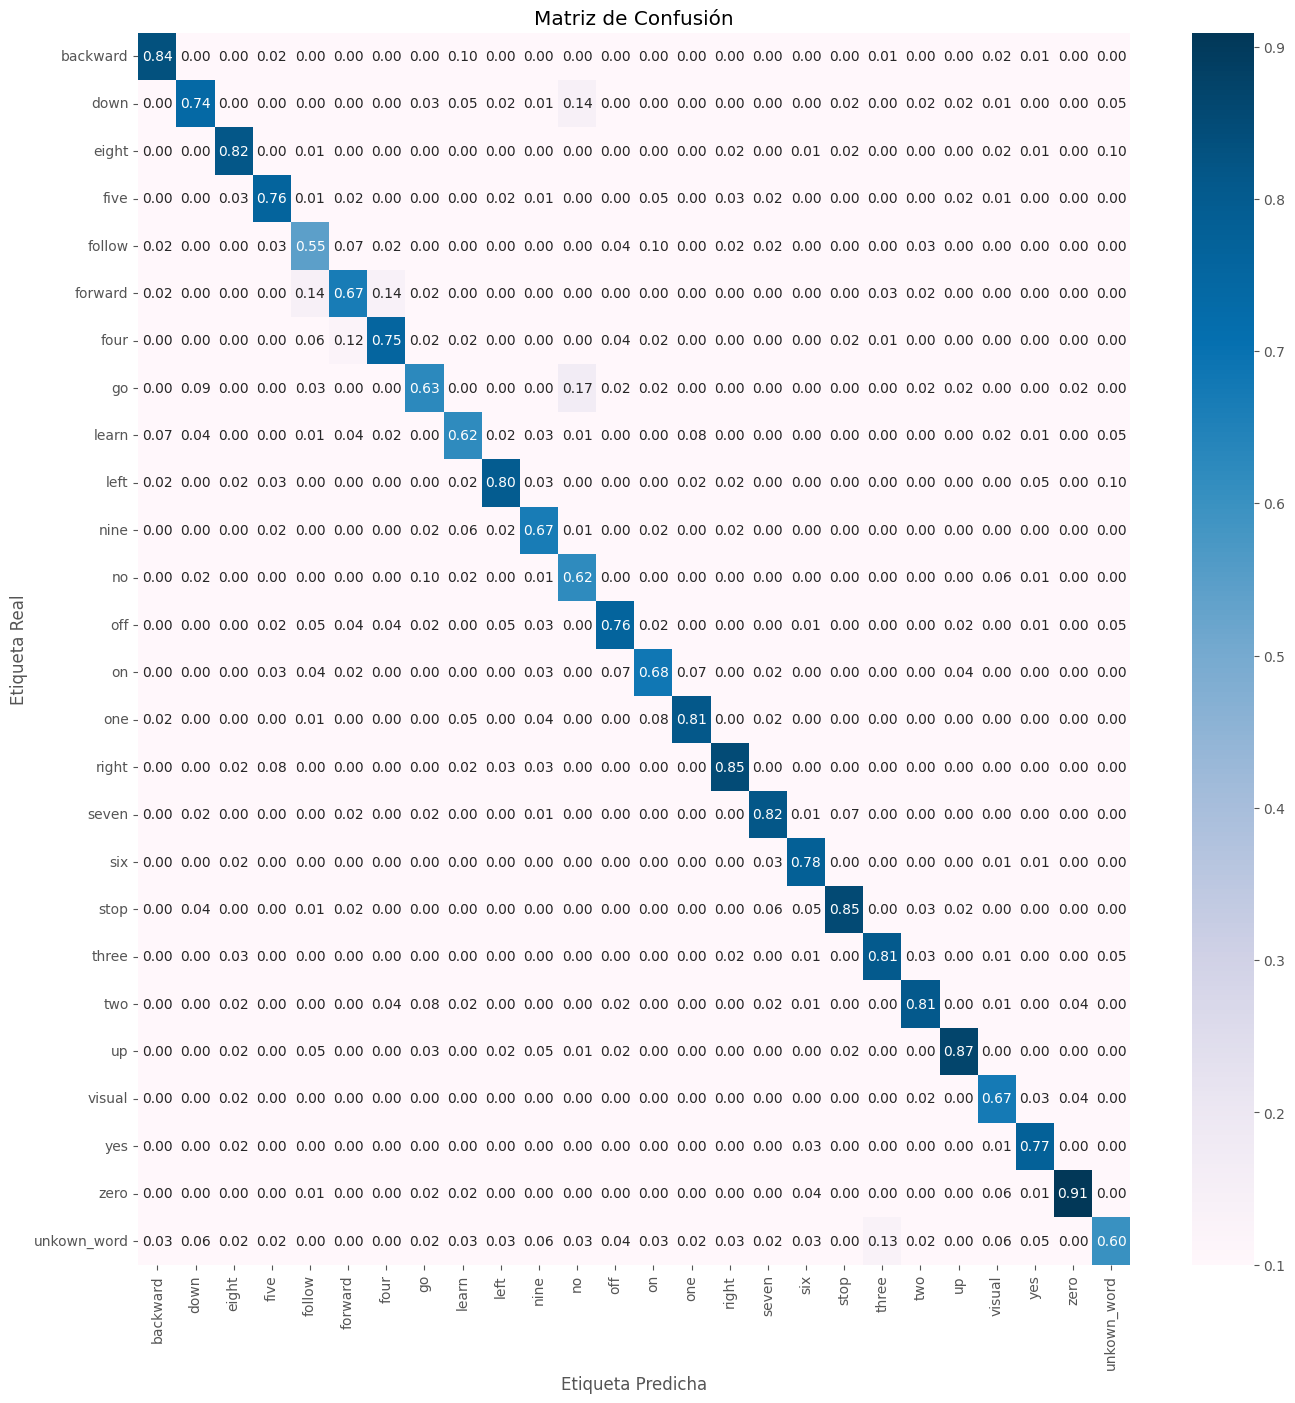

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_0_03, h_exp_a_cnn_mfcc_0_03, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_mfcc_0_04

In [ ]:
exp_a_cnn_mfcc_0_04 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_mfcc_0_04.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_0_04.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_0_04.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_mfcc_0_04 = exp_a_cnn_mfcc_0_04.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0576 - loss: 3.2010
Epoch 1: val_loss improved from inf to 2.49119, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.0577 - loss: 3.2006 - val_accuracy: 0.2649 - val_loss: 2.4912 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2457 - loss: 2.5045
Epoch 2: val_loss improved from 2.49119 to 1.92109, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.2466 - loss: 2.5014 - val_accuracy: 0.4747 - val_loss: 1.9211 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3863 - loss: 2.0130
Epoch 3: val_loss improved from 1.92109 to 1.54717, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3868 - loss: 2.0116 - val_accuracy: 0.5464 - val_loss: 1.5472 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4735 - loss: 1.7548
Epoch 4: val_loss improved from 1.54717 to 1.38633, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4734 - loss: 1.7546 - val_accuracy: 0.6075 - val_loss: 1.3863 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5076 - loss: 1.6219
Epoch 5: val_loss improved from 1.38633 to 1.23806, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5076 - loss: 1.6218 - val_accuracy: 0.6460 - val_loss: 1.2381 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5354 - loss: 1.5220
Epoch 6: val_loss improved from 1.23806 to 1.16281, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5354 - loss: 1.5219 - val_accuracy: 0.6649 - val_loss: 1.1628 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5472 - loss: 1.4517
Epoch 7: val_loss improved from 1.16281 to 1.10984, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5472 - loss: 1.4518 - val_accuracy: 0.6845 - val_loss: 1.1098 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5668 - loss: 1.3984
Epoch 8: val_loss improved from 1.10984 to 1.06275, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5668 - loss: 1.3984 - val_accuracy: 0.6996 - val_loss: 1.0628 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5862 - loss: 1.3362
Epoch 9: val_loss improved from 1.06275 to 1.02825, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5862 - loss: 1.3363 - val_accuracy: 0.7102 - val_loss: 1.0283 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5937 - loss: 1.3214
Epoch 10: val_loss improved from 1.02825 to 0.99137, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5935 - loss: 1.3213 - val_accuracy: 0.7185 - val_loss: 0.9914 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6027 - loss: 1.2841
Epoch 11: val_loss improved from 0.99137 to 0.98917, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6027 - loss: 1.2841 - val_accuracy: 0.7192 - val_loss: 0.9892 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6069 - loss: 1.2558
Epoch 12: val_loss improved from 0.98917 to 0.94523, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6068 - loss: 1.2560 - val_accuracy: 0.7366 - val_loss: 0.9452 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6161 - loss: 1.2362
Epoch 13: val_loss improved from 0.94523 to 0.93739, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6161 - loss: 1.2362 - val_accuracy: 0.7298 - val_loss: 0.9374 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6223 - loss: 1.2128
Epoch 14: val_loss improved from 0.93739 to 0.91951, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6223 - loss: 1.2128 - val_accuracy: 0.7374 - val_loss: 0.9195 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6304 - loss: 1.1993
Epoch 15: val_loss improved from 0.91951 to 0.91721, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6302 - loss: 1.1993 - val_accuracy: 0.7419 - val_loss: 0.9172 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6316 - loss: 1.1891
Epoch 16: val_loss did not improve from 0.91721
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6315 - loss: 1.1892 - val_accuracy: 0.7374 - val_loss: 0.9181 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6392 - loss: 1.1602
Epoch 17: val_loss improved from 0.91721 to 0.88984, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6392 - loss: 1.1605 - val_accuracy: 0.7404 - val_loss: 0.8898 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6394 - loss: 1.1625
Epoch 18: val_loss improved from 0.88984 to 0.87959, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6393 - loss: 1.1626 - val_accuracy: 0.7502 - val_loss: 0.8796 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6432 - loss: 1.1523
Epoch 19: val_loss improved from 0.87959 to 0.87731, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6430 - loss: 1.1525 - val_accuracy: 0.7434 - val_loss: 0.8773 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6472 - loss: 1.1340
Epoch 20: val_loss improved from 0.87731 to 0.86914, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6472 - loss: 1.1340 - val_accuracy: 0.7502 - val_loss: 0.8691 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6493 - loss: 1.1337
Epoch 21: val_loss improved from 0.86914 to 0.85979, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6493 - loss: 1.1336 - val_accuracy: 0.7479 - val_loss: 0.8598 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6525 - loss: 1.1255
Epoch 22: val_loss improved from 0.85979 to 0.85258, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6525 - loss: 1.1255 - val_accuracy: 0.7525 - val_loss: 0.8526 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6452 - loss: 1.1300
Epoch 23: val_loss did not improve from 0.85258
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6452 - loss: 1.1300 - val_accuracy: 0.7585 - val_loss: 0.8586 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6481 - loss: 1.1194
Epoch 24: val_loss improved from 0.85258 to 0.84715, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6480 - loss: 1.1195 - val_accuracy: 0.7585 - val_loss: 0.8472 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6520 - loss: 1.1081
Epoch 25: val_loss did not improve from 0.84715
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6520 - loss: 1.1082 - val_accuracy: 0.7525 - val_loss: 0.8486 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6526 - loss: 1.1014
Epoch 26: val_loss improved from 0.84715 to 0.84584, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6526 - loss: 1.1017 - val_accuracy: 0.7585 - val_loss: 0.8458 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6558 - loss: 1.1068
Epoch 27: val_loss did not improve from 0.84584
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6556 - loss: 1.1071 - val_accuracy: 0.7555 - val_loss: 0.8465 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6540 - loss: 1.0952
Epoch 28: val_loss improved from 0.84584 to 0.83762, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6540 - loss: 1.0952 - val_accuracy: 0.7660 - val_loss: 0.8376 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6531 - loss: 1.0940
Epoch 29: val_loss improved from 0.83762 to 0.83560, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6531 - loss: 1.0941 - val_accuracy: 0.7570 - val_loss: 0.8356 - learning_rate: 5.2335e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.7101286972462485e-05.
Epoch 30/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6530 - loss: 1.0978
Epoch 30: val_loss improved from 0.83560 to 0.83238, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6530 - loss: 1.0981 - val_accuracy: 0.7615 - val_loss: 0.8324 - learning_rate: 4.7101e-05

Epoch 31: LearningRateScheduler setting learning rate to 4.239115827521624e-05.
Epoch 31/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6577 - loss: 1.0912
Epoch 31: val_loss did not improve from 0.83238
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6577 - loss: 1.0913 - val_accuracy: 0.7638 - val_loss: 0.8336 - learning_rate: 4.2391e-05

Epoch 32: LearningRateScheduler setting learning rate to 3.8152042447694614e-05.
Epoch 32/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6579 - loss: 1.0846
Epoch 32: val_loss did not improve from 0.83238
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6579 - loss: 1.0850 - val_accuracy: 0.7675 - val_loss: 0.8342 - learning_rate: 3.8152e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.433683820292515e-05.
Epoch 33/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6598 - loss: 1.0904 - val_accuracy: 0.7668 - val_loss: 0.8295 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6575 - loss: 1.0830
Epoch 34: val_loss improved from 0.82952 to 0.82755, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6574 - loss: 1.0831 - val_accuracy: 0.7653 - val_loss: 0.8276 - learning_rate: 3.0903e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.7812838944369376e-05.
Epoch 35/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6561 - loss: 1.0907
Epoch 35: val_loss improved from 0.82755 to 0.82640, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6561 - loss: 1.0907 - val_accuracy: 0.7660 - val_loss: 0.8264 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6648 - loss: 1.0727
Epoch 36: val_loss improved from 0.82640 to 0.82366, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6647 - loss: 1.0730 - val_accuracy: 0.7683 - val_loss: 0.8237 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6613 - loss: 1.0628
Epoch 37: val_loss improved from 0.82366 to 0.82274, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6613 - loss: 1.0629 - val_accuracy: 0.7645 - val_loss: 0.8227 - learning_rate: 2.2528e-05

Epoch 38: LearningRateScheduler setting learning rate to 2.0275559590445276e-05.
Epoch 38/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6688 - loss: 1.0734
Epoch 38: val_loss improved from 0.82274 to 0.82267, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6687 - loss: 1.0736 - val_accuracy: 0.7660 - val_loss: 0.8227 - learning_rate: 2.0276e-05

Epoch 39: LearningRateScheduler setting learning rate to 1.824800363140075e-05.
Epoch 39/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6581 - loss: 1.0829
Epoch 39: val_loss improved from 0.82267 to 0.82115, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6581 - loss: 1.0830 - val_accuracy: 0.7623 - val_loss: 0.8212 - learning_rate: 1.8248e-05

Epoch 40: LearningRateScheduler setting learning rate to 1.6423203268260675e-05.
Epoch 40/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6645 - loss: 1.0628
Epoch 40: val_loss improved from 0.82115 to 0.81901, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6645 - loss: 1.0630 - val_accuracy: 0.7706 - val_loss: 0.8190 - learning_rate: 1.6423e-05

Epoch 41: LearningRateScheduler setting learning rate to 1.4780882941434608e-05.
Epoch 41/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6580 - loss: 1.0922
Epoch 41: val_loss improved from 0.81901 to 0.81882, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6580 - loss: 1.0919 - val_accuracy: 0.7660 - val_loss: 0.8188 - learning_rate: 1.4781e-05

Epoch 42: LearningRateScheduler setting learning rate to 1.3302794647291146e-05.
Epoch 42/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6610 - loss: 1.0805
Epoch 42: val_loss did not improve from 0.81882
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6611 - loss: 1.0805 - val_accuracy: 0.7691 - val_loss: 0.8196 - learning_rate: 1.3303e-05

Epoch 43: LearningRateScheduler setting learning rate to 1.1972515182562033e-05.
Epoch 43/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6658 - loss: 1.0577
Epoch 43: val_loss improved from 0.81882 to 0.81882, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6658 - loss: 1.0579 - val_accuracy: 0.7698 - val_loss: 0.8188 - learning_rate: 1.1973e-05

Epoch 44: LearningRateScheduler setting learning rate to 1.077526366430583e-05.
Epoch 44/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6742 - loss: 1.0672
Epoch 44: val_loss did not improve from 0.81882
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6741 - loss: 1.0673 - val_accuracy: 0.7675 - val_loss: 0.8189 - learning_rate: 1.0775e-05

Epoch 45: LearningRateScheduler setting learning rate to 9.697737297875246e-06.
Epoch 45/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6563 - loss: 1.0730
Epoch 45: val_loss did not improve from 0.81882
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6564 - loss: 1.0731 - val_accuracy: 0.7691 - val_loss: 0.8196 - learning_rate: 9.6977e-06

Epoch 46: LearningRateScheduler setting learning rate to 8.727963568087722e-06.
Epoch 46/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6657 - loss: 1.0577 - val_accuracy: 0.7683 - val_loss: 0.8183 - learning_rate: 7.0697e-06

Epoch 49: LearningRateScheduler setting learning rate to 6.36268544113595e-06.
Epoch 49/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6666 - loss: 1.0672
Epoch 49: val_loss did not improve from 0.81829
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6664 - loss: 1.0676 - val_accuracy: 0.7698 - val_loss: 0.8190 - learning_rate: 6.3627e-06

Epoch 50: LearningRateScheduler setting learning rate to 5.726416897022355e-06.
Epoch 50/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6759 - loss: 1.0466
Epoch 50: val_loss did not improve from 0.81829
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6758 - loss: 1.0468 - val_accuracy: 0.7698 - val_loss: 0.8186 - learning_rate: 5.7264e-06

Epoch 51: LearningRateScheduler setting learning rate to 5.15377520732012e-06.
Epoch 51/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6753 - loss: 1.0521 - val_accuracy: 0.7691 - val_loss: 0.8180 - learning_rate: 5.1538e-06

Epoch 52: LearningRateScheduler setting learning rate to 4.638397686588108e-06.
Epoch 52/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6627 - loss: 1.0677
Epoch 52: val_loss did not improve from 0.81796
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6627 - loss: 1.0679 - val_accuracy: 0.7698 - val_loss: 0.8183 - learning_rate: 4.6384e-06

Epoch 53: LearningRateScheduler setting learning rate to 4.174557917929297e-06.
Epoch 53/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6695 - loss: 1.0566
Epoch 53: val_loss improved from 0.81796 to 0.81758, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6694 - loss: 1.0569 - val_accuracy: 0.7698 - val_loss: 0.8176 - learning_rate: 4.1746e-06

Epoch 54: LearningRateScheduler setting learning rate to 3.7571021261363675e-06.
Epoch 54/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6698 - loss: 1.0661
Epoch 54: val_loss did not improve from 0.81758
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6698 - loss: 1.0663 - val_accuracy: 0.7698 - val_loss: 0.8182 - learning_rate: 3.7571e-06

Epoch 55: LearningRateScheduler setting learning rate to 3.381391913522731e-06.
Epoch 55/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6653 - loss: 1.0651
Epoch 55: val_loss did not improve from 0.81758
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6652 - loss: 1.0655 - val_accuracy: 0.7698 - val_loss: 0.8183 - learning_rate: 3.3814e-06

Epoch 56: LearningRateScheduler setting learning rate to 3.0432527221704577e-06.
Epoch 56/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6682 - loss: 1.0517 - val_accuracy: 0.7698 - val_loss: 0.8170 - learning_rate: 2.4650e-06

Epoch 59: LearningRateScheduler setting learning rate to 2.218531234462264e-06.
Epoch 59/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6665 - loss: 1.0599
Epoch 59: val_loss improved from 0.81698 to 0.81698, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6664 - loss: 1.0600 - val_accuracy: 0.7706 - val_loss: 0.8170 - learning_rate: 2.2185e-06

Epoch 60: LearningRateScheduler setting learning rate to 1.9966781110160375e-06.
Epoch 60/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6645 - loss: 1.0726
Epoch 60: val_loss did not improve from 0.81698
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6644 - loss: 1.0729 - val_accuracy: 0.7713 - val_loss: 0.8171 - learning_rate: 1.9967e-06

Epoch 61: LearningRateScheduler setting learning rate to 1.797010299914434e-06.
Epoch 61/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6677 - loss: 1.0572
Epoch 61: val_loss improved from 0.81698 to 0.81696, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6677 - loss: 1.0573 - val_accuracy: 0.7706 - val_loss: 0.8170 - learning_rate: 1.7970e-06

Epoch 62: LearningRateScheduler setting learning rate to 1.6173092699229906e-06.
Epoch 62/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6734 - loss: 1.0523
Epoch 62: val_loss improved from 0.81696 to 0.81681, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6733 - loss: 1.0529 - val_accuracy: 0.7698 - val_loss: 0.8168 - learning_rate: 1.6173e-06

Epoch 63: LearningRateScheduler setting learning rate to 1.4555783429306915e-06.
Epoch 63/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6598 - loss: 1.0858
Epoch 63: val_loss improved from 0.81681 to 0.81678, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6598 - loss: 1.0858 - val_accuracy: 0.7691 - val_loss: 0.8168 - learning_rate: 1.4556e-06

Epoch 64: LearningRateScheduler setting learning rate to 1.3100205086376223e-06.
Epoch 64/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6702 - loss: 1.0435
Epoch 64: val_loss improved from 0.81678 to 0.81650, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_04.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6701 - loss: 1.0437 - val_accuracy: 0.7698 - val_loss: 0.8165 - learning_rate: 1.3100e-06

Epoch 65: LearningRateScheduler setting learning rate to 1.1790184577738603e-06.
Epoch 65/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6649 - loss: 1.0668
Epoch 65: val_loss did not improve from 0.81650
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6649 - loss: 1.0670 - val_accuracy: 0.7698 - val_loss: 0.8167 - learning_rate: 1.1790e-06

Epoch 66: LearningRateScheduler setting learning rate to 1.061116611996474e-06.
Epoch 66/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6680 - loss: 1.0652
Epoch 66: val_loss did not improve from 0.81650
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6679 - loss: 1.0654 - val_accuracy: 0.7698 - val_loss: 0.8168 - learning_rate: 1.0611e-06

Epoch 67: LearningRateScheduler setting learning rate to 9.550049507968267e-07.
Epoch 67/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

In [ ]:
exp_a_cnn_mfcc_0_04.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 23, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 9, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 2, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 315,632 (1.20 MB)

 Trainable params: 105,210 (410.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 210,422 (821.96 KB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


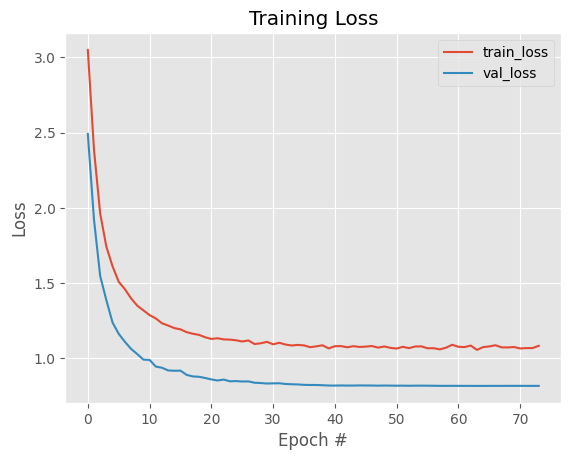

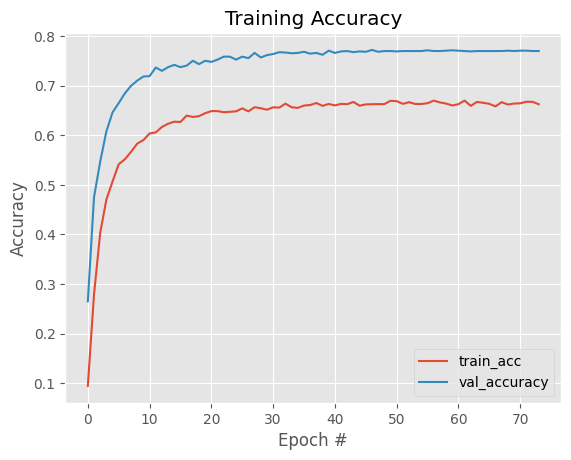

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.98      0.84      0.90        62
        down       0.75      0.66      0.70        62
       eight       0.86      0.90      0.88        62
        five       0.73      0.69      0.71        62
      follow       0.59      0.66      0.63        62
     forward       0.64      0.55      0.59        62
        four       0.72      0.69      0.70        62
          go       0.67      0.69      0.68        62
       learn       0.73      0.71      0.72        62
        left       0.72      0.66      0.69        62
        nine       0.79      0.87      0.83        62
          no       0.62      0.74      0.68        62
         off       0.76      0.73      0.74        62
          on       0.75      0.85      0.80        62
         one       0.84      0.87      0.86        62
       right       0.88      0.69      0.77        62
       seven       0.79      0.85      0.82       

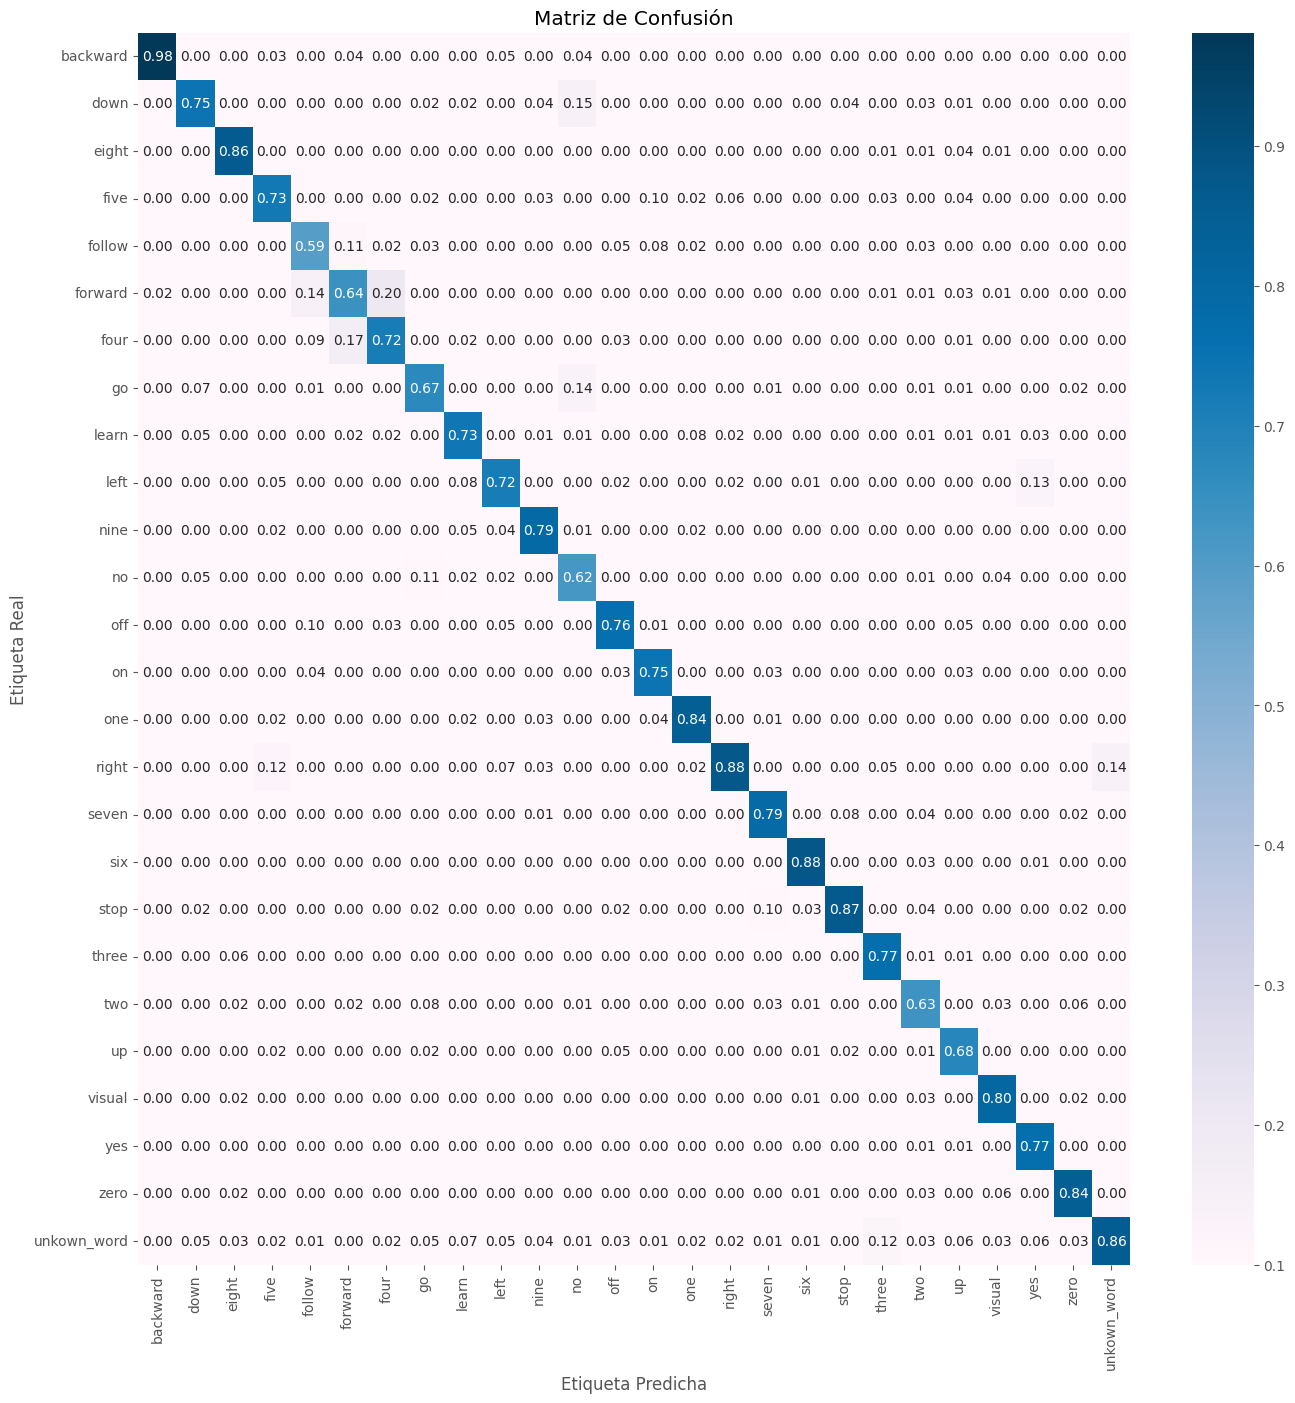

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_0_04, h_exp_a_cnn_mfcc_0_04, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_mfcc_0_05

In [ ]:
exp_a_cnn_mfcc_0_05 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_mfcc_0_05.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_0_05.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_0_05.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_mfcc_0_05 = exp_a_cnn_mfcc_0_05.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0739 - loss: 3.3798
Epoch 1: val_loss improved from inf to 2.93722, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.0740 - loss: 3.3790 - val_accuracy: 0.1532 - val_loss: 2.9372 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2777 - loss: 2.4002
Epoch 2: val_loss improved from 2.93722 to 1.85176, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2787 - loss: 2.3963 - val_accuracy: 0.4558 - val_loss: 1.8518 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4101 - loss: 1.8969
Epoch 3: val_loss improved from 1.85176 to 1.30039, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4104 - loss: 1.8957 - val_accuracy: 0.6008 - val_loss: 1.3004 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4848 - loss: 1.6280
Epoch 4: val_loss improved from 1.30039 to 1.17105, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4850 - loss: 1.6276 - val_accuracy: 0.6657 - val_loss: 1.1710 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5525 - loss: 1.4385
Epoch 5: val_loss improved from 1.17105 to 1.02410, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5526 - loss: 1.4379 - val_accuracy: 0.6974 - val_loss: 1.0241 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5870 - loss: 1.3226
Epoch 6: val_loss improved from 1.02410 to 0.94356, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5870 - loss: 1.3225 - val_accuracy: 0.7185 - val_loss: 0.9436 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6197 - loss: 1.2117
Epoch 7: val_loss improved from 0.94356 to 0.91158, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6197 - loss: 1.2118 - val_accuracy: 0.7321 - val_loss: 0.9116 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6365 - loss: 1.1682
Epoch 8: val_loss improved from 0.91158 to 0.86950, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6365 - loss: 1.1680 - val_accuracy: 0.7306 - val_loss: 0.8695 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6554 - loss: 1.1117
Epoch 9: val_loss improved from 0.86950 to 0.81614, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6555 - loss: 1.1113 - val_accuracy: 0.7547 - val_loss: 0.8161 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6719 - loss: 1.0541
Epoch 10: val_loss improved from 0.81614 to 0.77133, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6718 - loss: 1.0541 - val_accuracy: 0.7668 - val_loss: 0.7713 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6860 - loss: 1.0110
Epoch 11: val_loss improved from 0.77133 to 0.74887, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6859 - loss: 1.0110 - val_accuracy: 0.7774 - val_loss: 0.7489 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6913 - loss: 0.9797
Epoch 12: val_loss improved from 0.74887 to 0.73816, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6913 - loss: 0.9797 - val_accuracy: 0.7774 - val_loss: 0.7382 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6923 - loss: 0.9718
Epoch 13: val_loss improved from 0.73816 to 0.72752, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6924 - loss: 0.9717 - val_accuracy: 0.7774 - val_loss: 0.7275 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7112 - loss: 0.9436
Epoch 14: val_loss improved from 0.72752 to 0.69078, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7110 - loss: 0.9435 - val_accuracy: 0.7970 - val_loss: 0.6908 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7108 - loss: 0.9255
Epoch 15: val_loss improved from 0.69078 to 0.68570, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7108 - loss: 0.9255 - val_accuracy: 0.7955 - val_loss: 0.6857 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7162 - loss: 0.8963
Epoch 16: val_loss improved from 0.68570 to 0.67882, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7162 - loss: 0.8964 - val_accuracy: 0.7970 - val_loss: 0.6788 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7177 - loss: 0.8864
Epoch 17: val_loss improved from 0.67882 to 0.65633, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7177 - loss: 0.8864 - val_accuracy: 0.8008 - val_loss: 0.6563 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7228 - loss: 0.8597
Epoch 18: val_loss did not improve from 0.65633
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7229 - loss: 0.8597 - val_accuracy: 0.7970 - val_loss: 0.6594 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7332 - loss: 0.8662
Epoch 19: val_loss improved from 0.65633 to 0.65146, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7332 - loss: 0.8662 - val_accuracy: 0.8023 - val_loss: 0.6515 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7306 - loss: 0.8419
Epoch 20: val_loss improved from 0.65146 to 0.63965, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7307 - loss: 0.8420 - val_accuracy: 0.8045 - val_loss: 0.6397 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7322 - loss: 0.8441
Epoch 21: val_loss improved from 0.63965 to 0.63581, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7322 - loss: 0.8440 - val_accuracy: 0.8121 - val_loss: 0.6358 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7468 - loss: 0.8229
Epoch 22: val_loss improved from 0.63581 to 0.63454, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7468 - loss: 0.8229 - val_accuracy: 0.8083 - val_loss: 0.6345 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7415 - loss: 0.8210
Epoch 23: val_loss improved from 0.63454 to 0.63002, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7415 - loss: 0.8212 - val_accuracy: 0.8060 - val_loss: 0.6300 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7463 - loss: 0.8155
Epoch 24: val_loss improved from 0.63002 to 0.62604, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7462 - loss: 0.8156 - val_accuracy: 0.8128 - val_loss: 0.6260 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7465 - loss: 0.8088
Epoch 25: val_loss improved from 0.62604 to 0.62043, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7465 - loss: 0.8089 - val_accuracy: 0.8113 - val_loss: 0.6204 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7474 - loss: 0.8014
Epoch 26: val_loss did not improve from 0.62043
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7474 - loss: 0.8015 - val_accuracy: 0.8068 - val_loss: 0.6224 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7487 - loss: 0.7917
Epoch 27: val_loss did not improve from 0.62043
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7486 - loss: 0.7917 - val_accuracy: 0.8091 - val_loss: 0.6217 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7531 - loss: 0.7931 - val_accuracy: 0.8143 - val_loss: 0.6175 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7469 - loss: 0.7990
Epoch 29: val_loss did not improve from 0.61748
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7469 - loss: 0.7991 - val_accuracy: 0.8136 - val_loss: 0.6186 - learning_rate: 5.2335e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.7101286972462485e-05.
Epoch 30/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7462 - loss: 0.8071
Epoch 30: val_loss improved from 0.61748 to 0.61618, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7462 - loss: 0.8071 - val_accuracy: 0.8166 - val_loss: 0.6162 - learning_rate: 4.7101e-05

Epoch 31: LearningRateScheduler setting learning rate to 4.239115827521624e-05.
Epoch 31/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7578 - loss: 0.7759
Epoch 31: val_loss improved from 0.61618 to 0.61498, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7577 - loss: 0.7760 - val_accuracy: 0.8264 - val_loss: 0.6150 - learning_rate: 4.2391e-05

Epoch 32: LearningRateScheduler setting learning rate to 3.8152042447694614e-05.
Epoch 32/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7481 - loss: 0.7976
Epoch 32: val_loss improved from 0.61498 to 0.61258, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7481 - loss: 0.7975 - val_accuracy: 0.8196 - val_loss: 0.6126 - learning_rate: 3.8152e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.433683820292515e-05.
Epoch 33/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7594 - loss: 0.7693
Epoch 33: val_loss improved from 0.61258 to 0.61012, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7594 - loss: 0.7694 - val_accuracy: 0.8234 - val_loss: 0.6101 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7593 - loss: 0.7735
Epoch 34: val_loss did not improve from 0.61012
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7592 - loss: 0.7736 - val_accuracy: 0.8234 - val_loss: 0.6104 - learning_rate: 3.0903e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.7812838944369376e-05.
Epoch 35/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7610 - loss: 0.7598
Epoch 35: val_loss did not improve from 0.61012
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7609 - loss: 0.7602 - val_accuracy: 0.8242 - val_loss: 0.6102 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7555 - loss: 0.7906 - val_accuracy: 0.8242 - val_loss: 0.6095 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7624 - loss: 0.7588
Epoch 37: val_loss improved from 0.60948 to 0.60712, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7624 - loss: 0.7589 - val_accuracy: 0.8249 - val_loss: 0.6071 - learning_rate: 2.2528e-05

Epoch 38: LearningRateScheduler setting learning rate to 2.0275559590445276e-05.
Epoch 38/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7565 - loss: 0.7727
Epoch 38: val_loss improved from 0.60712 to 0.60513, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7564 - loss: 0.7728 - val_accuracy: 0.8257 - val_loss: 0.6051 - learning_rate: 2.0276e-05

Epoch 39: LearningRateScheduler setting learning rate to 1.824800363140075e-05.
Epoch 39/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7588 - loss: 0.7597
Epoch 39: val_loss improved from 0.60513 to 0.60500, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7588 - loss: 0.7597 - val_accuracy: 0.8272 - val_loss: 0.6050 - learning_rate: 1.8248e-05

Epoch 40: LearningRateScheduler setting learning rate to 1.6423203268260675e-05.
Epoch 40/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7522 - loss: 0.7667
Epoch 40: val_loss improved from 0.60500 to 0.60408, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7522 - loss: 0.7667 - val_accuracy: 0.8264 - val_loss: 0.6041 - learning_rate: 1.6423e-05

Epoch 41: LearningRateScheduler setting learning rate to 1.4780882941434608e-05.
Epoch 41/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7569 - loss: 0.7721
Epoch 41: val_loss did not improve from 0.60408
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7569 - loss: 0.7720 - val_accuracy: 0.8257 - val_loss: 0.6042 - learning_rate: 1.4781e-05

Epoch 42: LearningRateScheduler setting learning rate to 1.3302794647291146e-05.
Epoch 42/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7591 - loss: 0.7556
Epoch 42: val_loss improved from 0.60408 to 0.60239, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7590 - loss: 0.7557 - val_accuracy: 0.8279 - val_loss: 0.6024 - learning_rate: 1.3303e-05

Epoch 43: LearningRateScheduler setting learning rate to 1.1972515182562033e-05.
Epoch 43/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7563 - loss: 0.7688
Epoch 43: val_loss did not improve from 0.60239
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7563 - loss: 0.7688 - val_accuracy: 0.8279 - val_loss: 0.6027 - learning_rate: 1.1973e-05

Epoch 44: LearningRateScheduler setting learning rate to 1.077526366430583e-05.
Epoch 44/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7587 - loss: 0.7610
Epoch 44: val_loss improved from 0.60239 to 0.60216, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7587 - loss: 0.7610 - val_accuracy: 0.8272 - val_loss: 0.6022 - learning_rate: 1.0775e-05

Epoch 45: LearningRateScheduler setting learning rate to 9.697737297875246e-06.
Epoch 45/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7600 - loss: 0.7576
Epoch 45: val_loss improved from 0.60216 to 0.60156, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7600 - loss: 0.7576 - val_accuracy: 0.8264 - val_loss: 0.6016 - learning_rate: 9.6977e-06

Epoch 46: LearningRateScheduler setting learning rate to 8.727963568087722e-06.
Epoch 46/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7616 - loss: 0.7542
Epoch 46: val_loss improved from 0.60156 to 0.60123, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7616 - loss: 0.7542 - val_accuracy: 0.8264 - val_loss: 0.6012 - learning_rate: 8.7280e-06

Epoch 47: LearningRateScheduler setting learning rate to 7.85516721127895e-06.
Epoch 47/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7598 - loss: 0.7693
Epoch 47: val_loss did not improve from 0.60123
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7598 - loss: 0.7693 - val_accuracy: 0.8264 - val_loss: 0.6016 - learning_rate: 7.8552e-06

Epoch 48: LearningRateScheduler setting learning rate to 7.069650490151056e-06.
Epoch 48/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7607 - loss: 0.7554
Epoch 48: val_loss did not improve from 0.60123
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7606 - loss: 0.7557 - val_accuracy: 0.8279 - val_loss: 0.6014 - learning_rate: 7.0697e-06

Epoch 49: LearningRateScheduler setting learning rate to 6.36268544113595e-06.
Epoch 49/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7616 - loss: 0.7478 - val_accuracy: 0.8287 - val_loss: 0.6012 - learning_rate: 6.3627e-06

Epoch 50: LearningRateScheduler setting learning rate to 5.726416897022355e-06.
Epoch 50/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7629 - loss: 0.7469
Epoch 50: val_loss improved from 0.60121 to 0.60077, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7627 - loss: 0.7472 - val_accuracy: 0.8287 - val_loss: 0.6008 - learning_rate: 5.7264e-06

Epoch 51: LearningRateScheduler setting learning rate to 5.15377520732012e-06.
Epoch 51/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7620 - loss: 0.7636
Epoch 51: val_loss improved from 0.60077 to 0.60031, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7620 - loss: 0.7636 - val_accuracy: 0.8287 - val_loss: 0.6003 - learning_rate: 5.1538e-06

Epoch 52: LearningRateScheduler setting learning rate to 4.638397686588108e-06.
Epoch 52/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7674 - loss: 0.7546
Epoch 52: val_loss did not improve from 0.60031
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7673 - loss: 0.7546 - val_accuracy: 0.8287 - val_loss: 0.6004 - learning_rate: 4.6384e-06

Epoch 53: LearningRateScheduler setting learning rate to 4.174557917929297e-06.
Epoch 53/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7633 - loss: 0.7450
Epoch 53: val_loss did not improve from 0.60031
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7633 - loss: 0.7450 - val_accuracy: 0.8287 - val_loss: 0.6007 - learning_rate: 4.1746e-06

Epoch 54: LearningRateScheduler setting learning rate to 3.7571021261363675e-06.
Epoch 54/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7618 - loss: 0.7581 - val_accuracy: 0.8272 - val_loss: 0.6002 - learning_rate: 2.7389e-06

Epoch 58: LearningRateScheduler setting learning rate to 2.465034704958071e-06.
Epoch 58/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7623 - loss: 0.7490
Epoch 58: val_loss improved from 0.60022 to 0.60008, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7623 - loss: 0.7491 - val_accuracy: 0.8279 - val_loss: 0.6001 - learning_rate: 2.4650e-06

Epoch 59: LearningRateScheduler setting learning rate to 2.218531234462264e-06.
Epoch 59/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7670 - loss: 0.7640
Epoch 59: val_loss improved from 0.60008 to 0.59991, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7669 - loss: 0.7640 - val_accuracy: 0.8257 - val_loss: 0.5999 - learning_rate: 2.2185e-06

Epoch 60: LearningRateScheduler setting learning rate to 1.9966781110160375e-06.
Epoch 60/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7617 - loss: 0.7491
Epoch 60: val_loss improved from 0.59991 to 0.59950, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7616 - loss: 0.7491 - val_accuracy: 0.8264 - val_loss: 0.5995 - learning_rate: 1.9967e-06

Epoch 61: LearningRateScheduler setting learning rate to 1.797010299914434e-06.
Epoch 61/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7595 - loss: 0.7689
Epoch 61: val_loss did not improve from 0.59950
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7595 - loss: 0.7689 - val_accuracy: 0.8257 - val_loss: 0.5999 - learning_rate: 1.7970e-06

Epoch 62: LearningRateScheduler setting learning rate to 1.6173092699229906e-06.
Epoch 62/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7615 - loss: 0.7666
Epoch 62: val_loss improved from 0.59950 to 0.59942, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_05.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7615 - loss: 0.7666 - val_accuracy: 0.8264 - val_loss: 0.5994 - learning_rate: 1.6173e-06

Epoch 63: LearningRateScheduler setting learning rate to 1.4555783429306915e-06.
Epoch 63/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7604 - loss: 0.7748
Epoch 63: val_loss did not improve from 0.59942
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7604 - loss: 0.7747 - val_accuracy: 0.8272 - val_loss: 0.6000 - learning_rate: 1.4556e-06

Epoch 64: LearningRateScheduler setting learning rate to 1.3100205086376223e-06.
Epoch 64/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7500 - loss: 0.7909
Epoch 64: val_loss did not improve from 0.59942
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7501 - loss: 0.7907 - val_accuracy: 0.8264 - val_loss: 0.6001 - learning_rate: 1.3100e-06

Epoch 65: LearningRateScheduler setting learning rate to 1.1790184577738603e-06.
Epoch 65/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7603 - loss: 0.7631 - val_accuracy: 0.8272 - val_loss: 0.5992 - learning_rate: 8.5950e-07

Epoch 69: LearningRateScheduler setting learning rate to 7.735540101454298e-07.
Epoch 69/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7715 - loss: 0.7306
Epoch 69: val_loss did not improve from 0.59921
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7714 - loss: 0.7307 - val_accuracy: 0.8264 - val_loss: 0.5996 - learning_rate: 7.7355e-07

Epoch 70: LearningRateScheduler setting learning rate to 6.961986091308867e-07.
Epoch 70/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7674 - loss: 0.7609
Epoch 70: val_loss did not improve from 0.59921
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7673 - loss: 0.7610 - val_accuracy: 0.8272 - val_loss: 0.5998 - learning_rate: 6.9620e-07

Epoch 71: LearningRateScheduler setting learning rate to 6.265787482177981e-07.
Epoch 71/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

In [ ]:
exp_a_cnn_mfcc_0_05.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 23, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 23, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 9, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 9, 13, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 2, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 2, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 317,424 (1.21 MB)

 Trainable params: 105,658 (412.73 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 211,318 (825.46 KB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


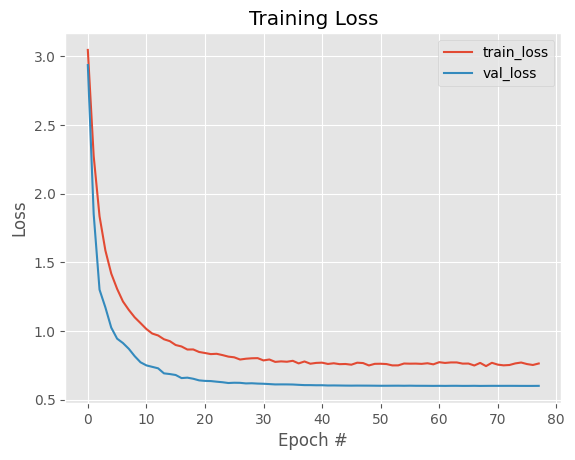

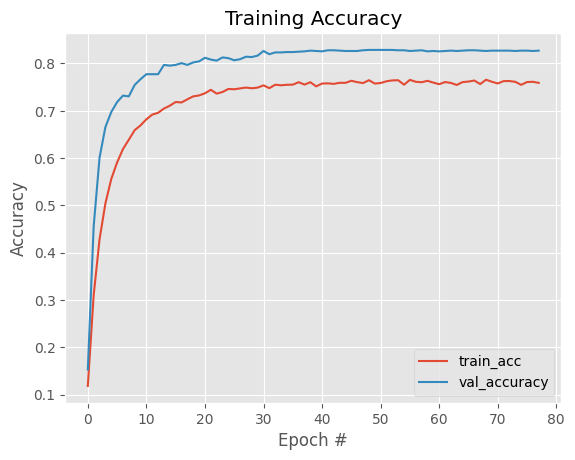

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.97      0.90      0.93        62
        down       0.78      0.69      0.74        62
       eight       0.90      0.92      0.91        62
        five       0.87      0.84      0.85        62
      follow       0.58      0.79      0.67        62
     forward       0.81      0.68      0.74        62
        four       0.75      0.73      0.74        62
          go       0.85      0.71      0.77        62
       learn       0.79      0.77      0.78        62
        left       0.86      0.81      0.83        62
        nine       0.89      0.90      0.90        62
          no       0.68      0.87      0.77        62
         off       0.89      0.81      0.85        62
          on       0.81      0.82      0.82        62
         one       0.87      0.89      0.88        62
       right       0.96      0.87      0.92        62
       seven       0.86      0.90      0.88       

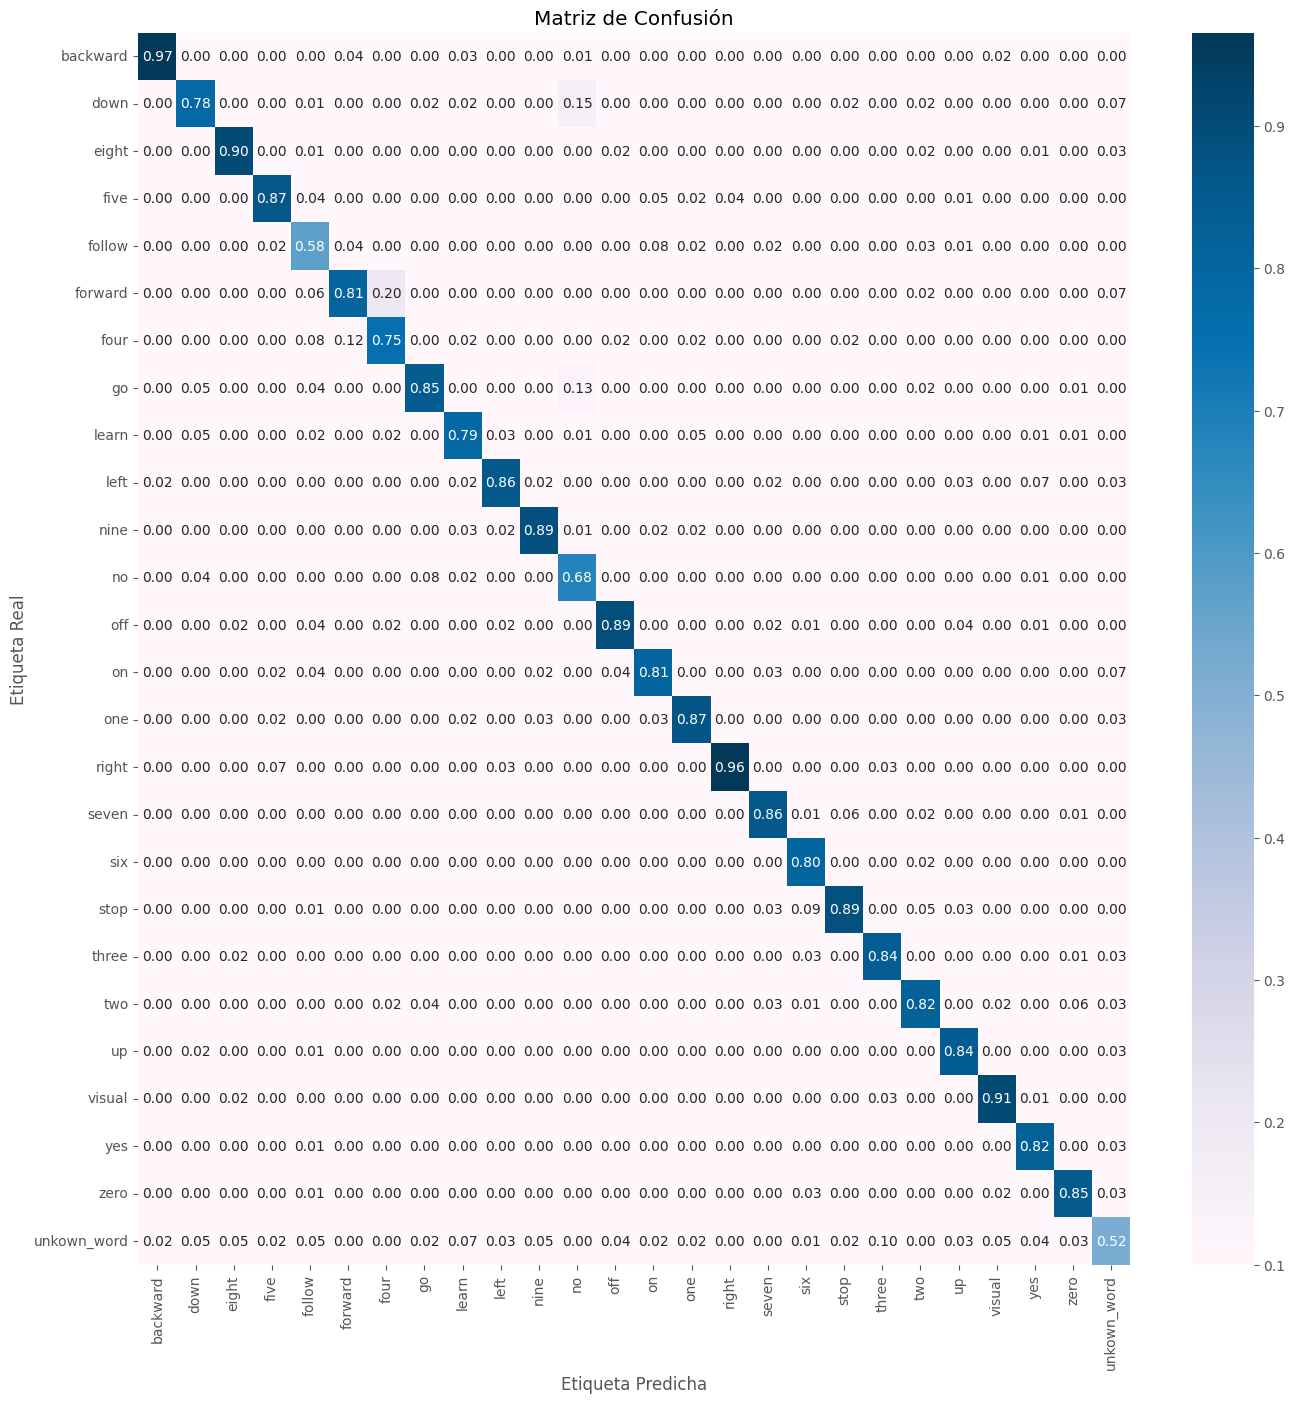

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_0_05, h_exp_a_cnn_mfcc_0_05, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_mfcc_0_06

In [ ]:
exp_a_cnn_mfcc_0_06 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_mfcc_0_06.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_0_06.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_0_06.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_mfcc_0_06 = exp_a_cnn_mfcc_0_06.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1421 - loss: 3.0351
Epoch 1: val_loss improved from inf to 2.54608, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.1423 - loss: 3.0341 - val_accuracy: 0.3094 - val_loss: 2.5461 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4671 - loss: 1.7478
Epoch 2: val_loss improved from 2.54608 to 1.28643, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4681 - loss: 1.7440 - val_accuracy: 0.6008 - val_loss: 1.2864 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6020 - loss: 1.2588
Epoch 3: val_loss improved from 1.28643 to 1.03521, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6022 - loss: 1.2583 - val_accuracy: 0.6815 - val_loss: 1.0352 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6710 - loss: 1.0425
Epoch 4: val_loss improved from 1.03521 to 0.91443, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6710 - loss: 1.0425 - val_accuracy: 0.7245 - val_loss: 0.9144 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7059 - loss: 0.9488
Epoch 5: val_loss improved from 0.91443 to 0.86009, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7059 - loss: 0.9486 - val_accuracy: 0.7434 - val_loss: 0.8601 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7418 - loss: 0.8246
Epoch 6: val_loss improved from 0.86009 to 0.73794, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7418 - loss: 0.8246 - val_accuracy: 0.7713 - val_loss: 0.7379 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7654 - loss: 0.7553
Epoch 7: val_loss improved from 0.73794 to 0.68305, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7654 - loss: 0.7553 - val_accuracy: 0.7925 - val_loss: 0.6831 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7720 - loss: 0.7207
Epoch 8: val_loss did not improve from 0.68305
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7720 - loss: 0.7206 - val_accuracy: 0.7887 - val_loss: 0.6957 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7961 - loss: 0.6608
Epoch 9: val_loss improved from 0.68305 to 0.67745, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7961 - loss: 0.6608 - val_accuracy: 0.7826 - val_loss: 0.6774 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7996 - loss: 0.6370
Epoch 10: val_loss did not improve from 0.67745
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7997 - loss: 0.6367 - val_accuracy: 0.7789 - val_loss: 0.6843 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8159 - loss: 0.5827
Epoch 11: val_loss improved from 0.67745 to 0.63199, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8159 - loss: 0.5828 - val_accuracy: 0.8038 - val_loss: 0.6320 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8204 - loss: 0.5700
Epoch 12: val_loss improved from 0.63199 to 0.62922, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8204 - loss: 0.5699 - val_accuracy: 0.8128 - val_loss: 0.6292 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8297 - loss: 0.5405
Epoch 13: val_loss improved from 0.62922 to 0.61410, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8297 - loss: 0.5406 - val_accuracy: 0.8045 - val_loss: 0.6141 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8340 - loss: 0.5254
Epoch 14: val_loss improved from 0.61410 to 0.60149, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8340 - loss: 0.5254 - val_accuracy: 0.8075 - val_loss: 0.6015 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8357 - loss: 0.5013
Epoch 15: val_loss improved from 0.60149 to 0.59537, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8358 - loss: 0.5013 - val_accuracy: 0.8166 - val_loss: 0.5954 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8481 - loss: 0.4771
Epoch 16: val_loss improved from 0.59537 to 0.57638, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8480 - loss: 0.4774 - val_accuracy: 0.8174 - val_loss: 0.5764 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8509 - loss: 0.4791
Epoch 17: val_loss improved from 0.57638 to 0.57604, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8509 - loss: 0.4790 - val_accuracy: 0.8181 - val_loss: 0.5760 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8585 - loss: 0.4450
Epoch 18: val_loss did not improve from 0.57604
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8585 - loss: 0.4450 - val_accuracy: 0.8234 - val_loss: 0.5762 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8592 - loss: 0.4441
Epoch 19: val_loss did not improve from 0.57604
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8593 - loss: 0.4441 - val_accuracy: 0.8226 - val_loss: 0.5795 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8627 - loss: 0.4306 - val_accuracy: 0.8279 - val_loss: 0.5651 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8670 - loss: 0.4184
Epoch 21: val_loss improved from 0.56509 to 0.56132, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8670 - loss: 0.4184 - val_accuracy: 0.8264 - val_loss: 0.5613 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8667 - loss: 0.4122
Epoch 22: val_loss improved from 0.56132 to 0.55613, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_06.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8667 - loss: 0.4122 - val_accuracy: 0.8264 - val_loss: 0.5561 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8714 - loss: 0.4043
Epoch 23: val_loss did not improve from 0.55613
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8713 - loss: 0.4043 - val_accuracy: 0.8234 - val_loss: 0.5594 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8670 - loss: 0.4026
Epoch 24: val_loss did not improve from 0.55613
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8671 - loss: 0.4025 - val_accuracy: 0.8287 - val_loss: 0.5593 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

In [ ]:
exp_a_cnn_mfcc_0_06.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 23, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 23, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 9, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 9, 13, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 2, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 317,424 (1.21 MB)

 Trainable params: 105,658 (412.73 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 211,318 (825.46 KB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


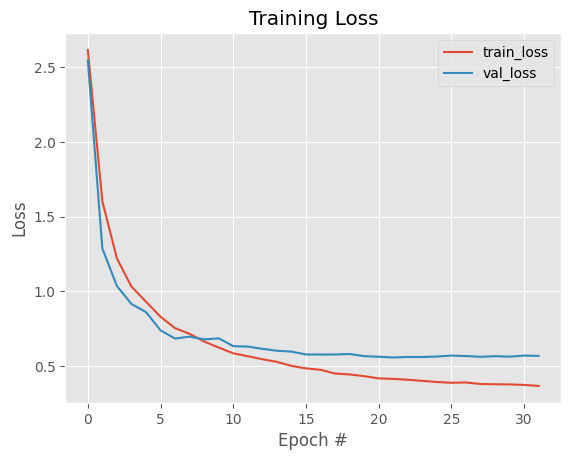

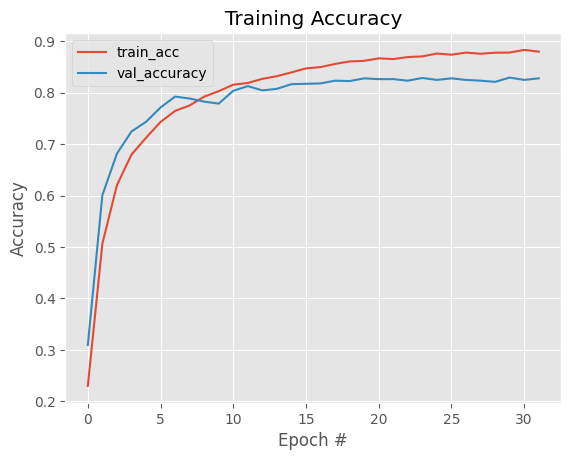

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.97      0.92      0.94        62
        down       0.86      0.69      0.77        62
       eight       0.89      0.95      0.92        62
        five       0.84      0.85      0.85        62
      follow       0.62      0.74      0.68        62
     forward       0.68      0.63      0.66        62
        four       0.68      0.63      0.66        62
          go       0.77      0.77      0.77        62
       learn       0.75      0.77      0.76        62
        left       0.92      0.76      0.83        62
        nine       0.81      0.95      0.87        62
          no       0.78      0.87      0.82        62
         off       0.89      0.77      0.83        62
          on       0.78      0.90      0.84        62
         one       0.90      0.87      0.89        62
       right       0.96      0.76      0.85        62
       seven       0.95      0.87      0.91       

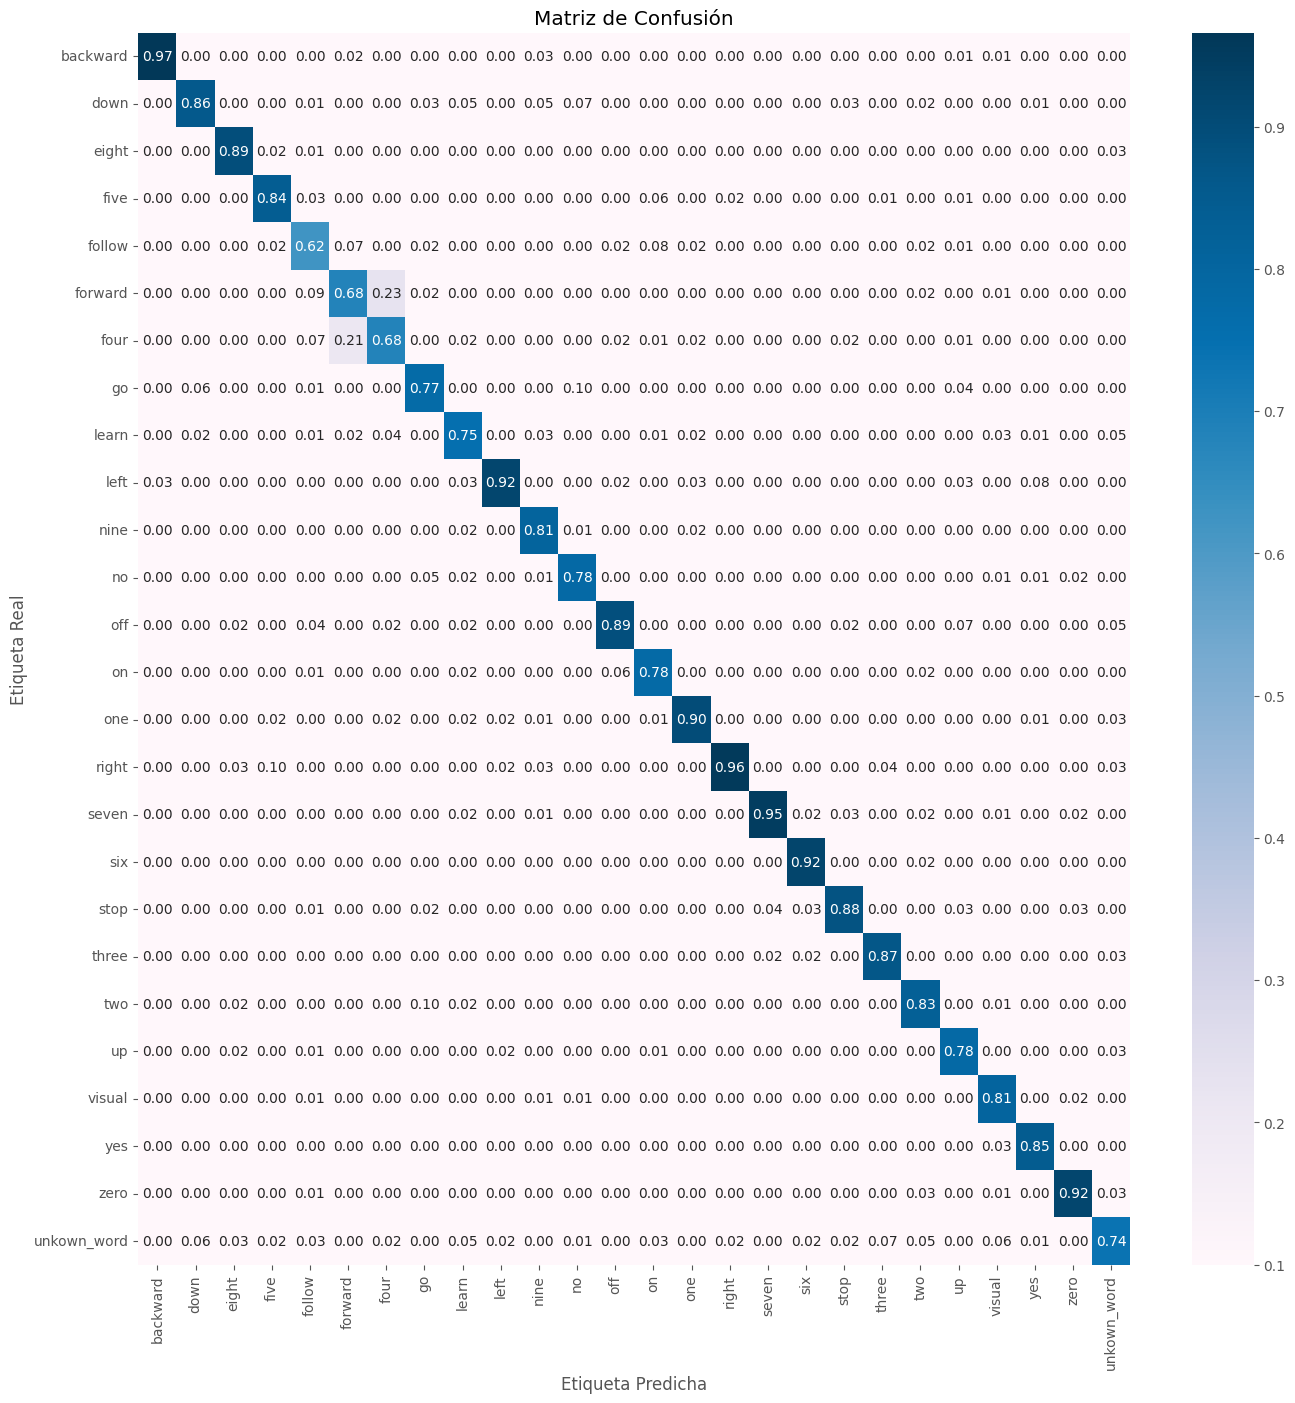

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_0_06, h_exp_a_cnn_mfcc_0_06, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_mfcc_0_07

In [ ]:
exp_a_cnn_mfcc_0_07 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_mfcc_0_07.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_0_07.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_0_07.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_mfcc_0_07 = exp_a_cnn_mfcc_0_07.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0855 - loss: 3.2112
Epoch 1: val_loss improved from inf to 2.90723, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.0857 - loss: 3.2104 - val_accuracy: 0.1094 - val_loss: 2.9072 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3762 - loss: 2.0340
Epoch 2: val_loss improved from 2.90723 to 1.45079, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3767 - loss: 2.0319 - val_accuracy: 0.5728 - val_loss: 1.4508 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5307 - loss: 1.4873
Epoch 3: val_loss improved from 1.45079 to 1.08880, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5309 - loss: 1.4870 - val_accuracy: 0.6808 - val_loss: 1.0888 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6065 - loss: 1.2581
Epoch 4: val_loss improved from 1.08880 to 0.99337, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6068 - loss: 1.2575 - val_accuracy: 0.7049 - val_loss: 0.9934 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6575 - loss: 1.0880
Epoch 5: val_loss improved from 0.99337 to 0.86899, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6576 - loss: 1.0877 - val_accuracy: 0.7426 - val_loss: 0.8690 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6966 - loss: 0.9903
Epoch 6: val_loss improved from 0.86899 to 0.76439, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6966 - loss: 0.9902 - val_accuracy: 0.7464 - val_loss: 0.7644 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7171 - loss: 0.9057
Epoch 7: val_loss improved from 0.76439 to 0.72390, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7172 - loss: 0.9055 - val_accuracy: 0.7645 - val_loss: 0.7239 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7404 - loss: 0.8578
Epoch 8: val_loss did not improve from 0.72390
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7404 - loss: 0.8575 - val_accuracy: 0.7698 - val_loss: 0.7257 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7542 - loss: 0.7981
Epoch 9: val_loss improved from 0.72390 to 0.69080, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7542 - loss: 0.7980 - val_accuracy: 0.7811 - val_loss: 0.6908 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7691 - loss: 0.7359
Epoch 10: val_loss improved from 0.69080 to 0.66408, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7691 - loss: 0.7359 - val_accuracy: 0.7947 - val_loss: 0.6641 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7794 - loss: 0.6978
Epoch 11: val_loss improved from 0.66408 to 0.64807, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7794 - loss: 0.6978 - val_accuracy: 0.7970 - val_loss: 0.6481 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7869 - loss: 0.6807
Epoch 12: val_loss did not improve from 0.64807
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7869 - loss: 0.6805 - val_accuracy: 0.7917 - val_loss: 0.6508 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7990 - loss: 0.6509
Epoch 13: val_loss improved from 0.64807 to 0.64467, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7990 - loss: 0.6509 - val_accuracy: 0.8008 - val_loss: 0.6447 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8057 - loss: 0.6185
Epoch 14: val_loss improved from 0.64467 to 0.60130, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8057 - loss: 0.6185 - val_accuracy: 0.8075 - val_loss: 0.6013 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8114 - loss: 0.5952
Epoch 15: val_loss did not improve from 0.60130
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8114 - loss: 0.5952 - val_accuracy: 0.8098 - val_loss: 0.6060 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8131 - loss: 0.5914
Epoch 16: val_loss did not improve from 0.60130
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8131 - loss: 0.5912 - val_accuracy: 0.8106 - val_loss: 0.6112 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8311 - loss: 0.5409 - val_accuracy: 0.8128 - val_loss: 0.5996 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8309 - loss: 0.5324
Epoch 19: val_loss improved from 0.59964 to 0.57364, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8309 - loss: 0.5325 - val_accuracy: 0.8249 - val_loss: 0.5736 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8316 - loss: 0.5262
Epoch 20: val_loss improved from 0.57364 to 0.57291, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8316 - loss: 0.5262 - val_accuracy: 0.8211 - val_loss: 0.5729 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8335 - loss: 0.5193
Epoch 21: val_loss improved from 0.57291 to 0.56291, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_07.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8335 - loss: 0.5193 - val_accuracy: 0.8204 - val_loss: 0.5629 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8375 - loss: 0.5061
Epoch 22: val_loss did not improve from 0.56291
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8375 - loss: 0.5060 - val_accuracy: 0.8166 - val_loss: 0.5760 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8436 - loss: 0.4850
Epoch 23: val_loss did not improve from 0.56291
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8437 - loss: 0.4851 - val_accuracy: 0.8151 - val_loss: 0.5679 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8429 - loss: 0.4946 - val_accuracy: 0.8279 - val_loss: 0.5624 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8449 - loss: 0.4841
Epoch 26: val_loss did not improve from 0.56236
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8450 - loss: 0.4838 - val_accuracy: 0.8211 - val_loss: 0.5709 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8499 - loss: 0.4748
Epoch 27: val_loss did not improve from 0.56236
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8499 - loss: 0.4746 - val_accuracy: 0.8249 - val_loss: 0.5664 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8567 - loss: 0.4476 - val_accuracy: 0.8279 - val_loss: 0.5568 - learning_rate: 4.2391e-05

Epoch 32: LearningRateScheduler setting learning rate to 3.8152042447694614e-05.
Epoch 32/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8485 - loss: 0.4599
Epoch 32: val_loss did not improve from 0.55678
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8486 - loss: 0.4599 - val_accuracy: 0.8279 - val_loss: 0.5575 - learning_rate: 3.8152e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.433683820292515e-05.
Epoch 33/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8506 - loss: 0.4693
Epoch 33: val_loss did not improve from 0.55678
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8507 - loss: 0.4689 - val_accuracy: 0.8257 - val_loss: 0.5604 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

In [ ]:
exp_a_cnn_mfcc_0_07.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 23, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 23, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 9, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 9, 13, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 2, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 2, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 337,200 (1.29 MB)

 Trainable params: 112,250 (438.48 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 224,502 (876.96 KB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


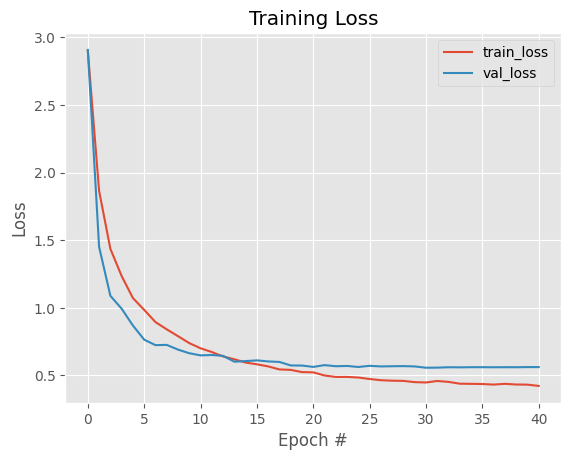

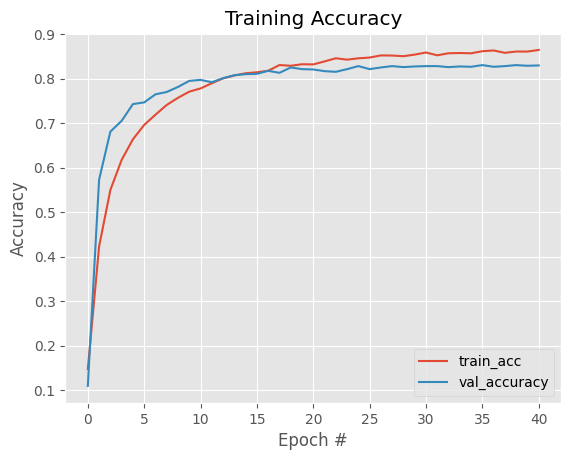

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.92      0.94      0.93        62
        down       0.91      0.84      0.87        62
       eight       0.91      0.94      0.92        62
        five       0.84      0.79      0.82        62
      follow       0.70      0.74      0.72        62
     forward       0.76      0.71      0.73        62
        four       0.78      0.81      0.79        62
          go       0.76      0.92      0.83        62
       learn       0.83      0.92      0.87        62
        left       0.96      0.82      0.89        62
        nine       0.88      0.94      0.91        62
          no       0.86      0.90      0.88        62
         off       0.90      0.84      0.87        62
          on       0.80      0.79      0.80        62
         one       0.91      0.84      0.87        62
       right       0.90      0.85      0.88        62
       seven       0.95      0.95      0.95       

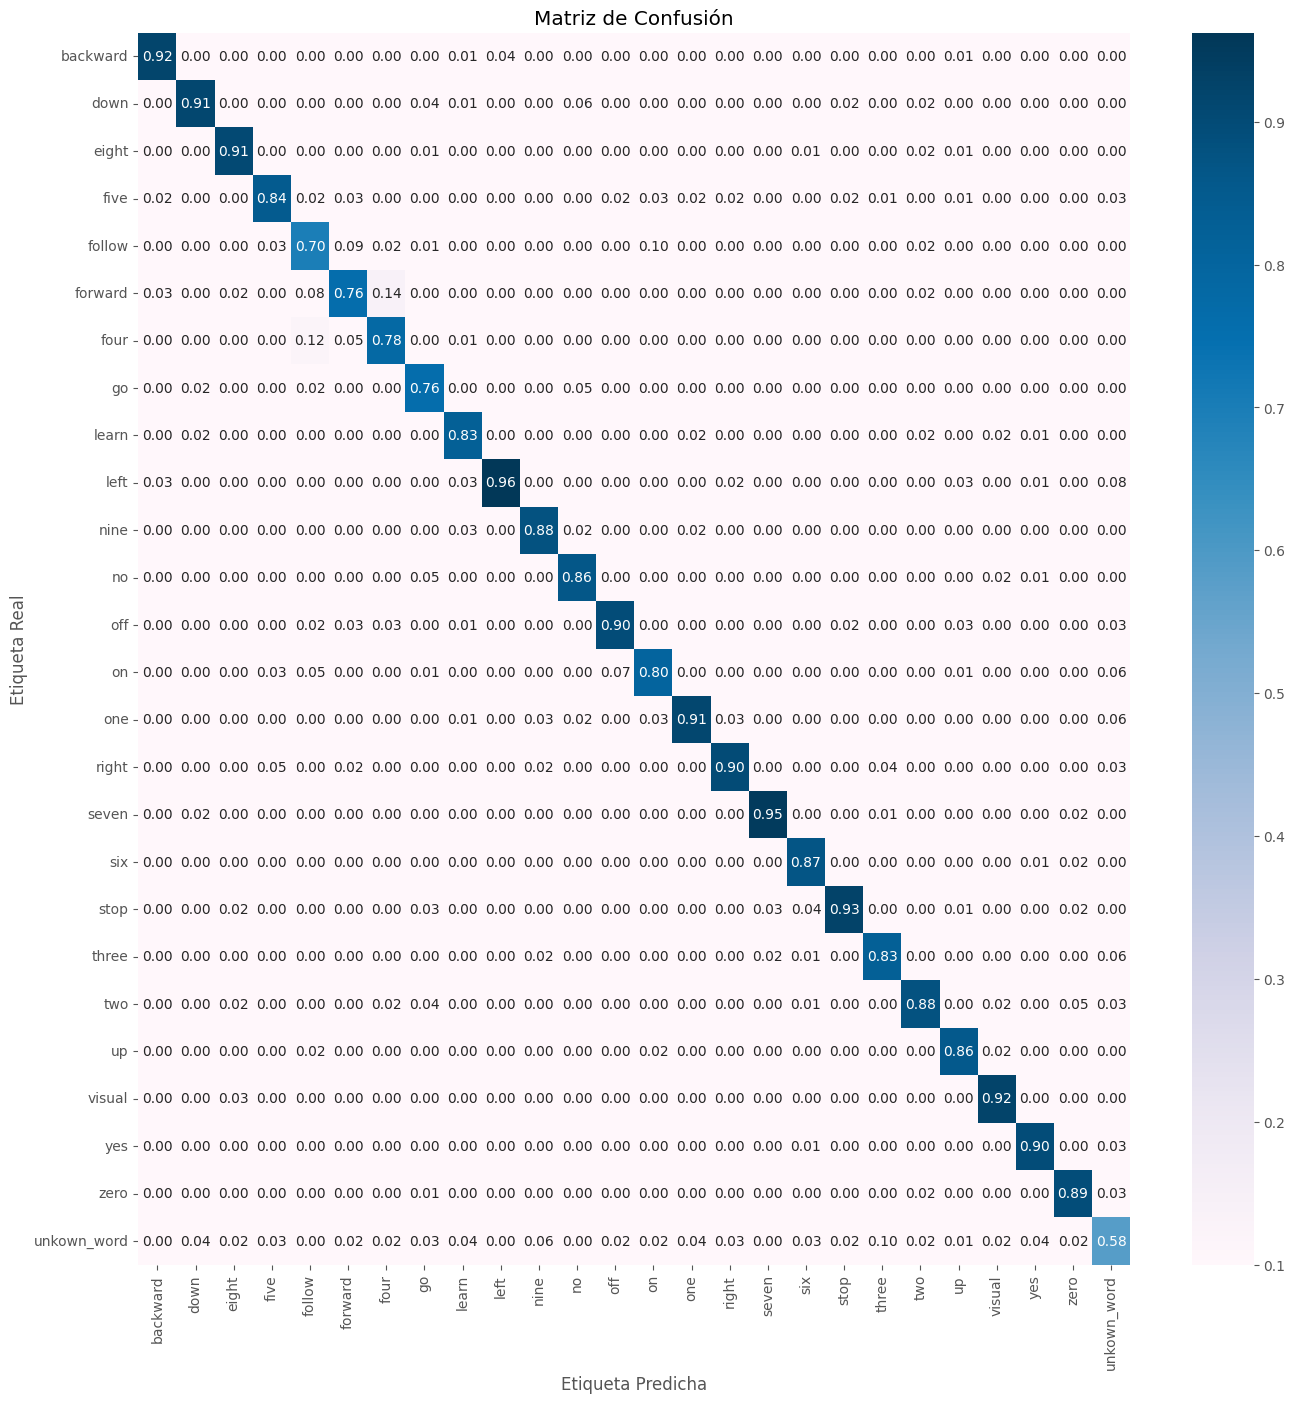

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_0_07, h_exp_a_cnn_mfcc_0_07, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_mfcc_0_08

In [ ]:
exp_a_cnn_mfcc_0_08 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_mfcc_0_08.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_0_08.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_0_08.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_mfcc_0_08 = exp_a_cnn_mfcc_0_08.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1443 - loss: 2.9642
Epoch 1: val_loss improved from inf to 2.43833, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.1446 - loss: 2.9631 - val_accuracy: 0.3374 - val_loss: 2.4383 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5095 - loss: 1.5745
Epoch 2: val_loss improved from 2.43833 to 1.22509, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5104 - loss: 1.5719 - val_accuracy: 0.6438 - val_loss: 1.2251 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6257 - loss: 1.1924
Epoch 3: val_loss improved from 1.22509 to 0.96810, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6260 - loss: 1.1916 - val_accuracy: 0.6906 - val_loss: 0.9681 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6859 - loss: 1.0100
Epoch 4: val_loss improved from 0.96810 to 0.86021, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6861 - loss: 1.0094 - val_accuracy: 0.7358 - val_loss: 0.8602 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7201 - loss: 0.8955
Epoch 5: val_loss improved from 0.86021 to 0.80931, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7202 - loss: 0.8953 - val_accuracy: 0.7494 - val_loss: 0.8093 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7461 - loss: 0.8157
Epoch 6: val_loss improved from 0.80931 to 0.72980, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7461 - loss: 0.8157 - val_accuracy: 0.7743 - val_loss: 0.7298 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7662 - loss: 0.7445
Epoch 7: val_loss did not improve from 0.72980
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7662 - loss: 0.7444 - val_accuracy: 0.7675 - val_loss: 0.7372 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7834 - loss: 0.6939
Epoch 8: val_loss improved from 0.72980 to 0.68538, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7834 - loss: 0.6936 - val_accuracy: 0.7842 - val_loss: 0.6854 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7996 - loss: 0.6442
Epoch 9: val_loss improved from 0.68538 to 0.63887, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7996 - loss: 0.6443 - val_accuracy: 0.8075 - val_loss: 0.6389 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8050 - loss: 0.6097
Epoch 10: val_loss did not improve from 0.63887
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8051 - loss: 0.6097 - val_accuracy: 0.7909 - val_loss: 0.6389 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8180 - loss: 0.5761
Epoch 11: val_loss improved from 0.63887 to 0.62747, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8180 - loss: 0.5759 - val_accuracy: 0.8083 - val_loss: 0.6275 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8218 - loss: 0.5619
Epoch 12: val_loss did not improve from 0.62747
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8218 - loss: 0.5619 - val_accuracy: 0.8091 - val_loss: 0.6402 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8300 - loss: 0.5318
Epoch 13: val_loss did not improve from 0.62747
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8300 - loss: 0.5317 - val_accuracy: 0.8045 - val_loss: 0.6285 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8427 - loss: 0.4974 - val_accuracy: 0.8113 - val_loss: 0.6168 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8517 - loss: 0.4684
Epoch 16: val_loss improved from 0.61678 to 0.59590, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_08.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8517 - loss: 0.4681 - val_accuracy: 0.8196 - val_loss: 0.5959 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8487 - loss: 0.4692
Epoch 17: val_loss did not improve from 0.59590
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8487 - loss: 0.4692 - val_accuracy: 0.8181 - val_loss: 0.6189 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8592 - loss: 0.4345
Epoch 18: val_loss did not improve from 0.59590
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8593 - loss: 0.4345 - val_accuracy: 0.8189 - val_loss: 0.6089 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8683 - loss: 0.4047 - val_accuracy: 0.8226 - val_loss: 0.5930 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8724 - loss: 0.3971
Epoch 22: val_loss did not improve from 0.59302
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8724 - loss: 0.3971 - val_accuracy: 0.8272 - val_loss: 0.6012 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8726 - loss: 0.3901
Epoch 23: val_loss did not improve from 0.59302
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8726 - loss: 0.3900 - val_accuracy: 0.8204 - val_loss: 0.6071 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8761 - loss: 0.3876 - val_accuracy: 0.8279 - val_loss: 0.5880 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8826 - loss: 0.3636
Epoch 25: val_loss did not improve from 0.58798
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8826 - loss: 0.3636 - val_accuracy: 0.8272 - val_loss: 0.6006 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8818 - loss: 0.3668
Epoch 26: val_loss did not improve from 0.58798
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8818 - loss: 0.3668 - val_accuracy: 0.8279 - val_loss: 0.5960 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

In [ ]:
exp_a_cnn_mfcc_0_08.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 23, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 23, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 9, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 9, 13, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 2, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 2, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 337,200 (1.29 MB)

 Trainable params: 112,250 (438.48 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 224,502 (876.96 KB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


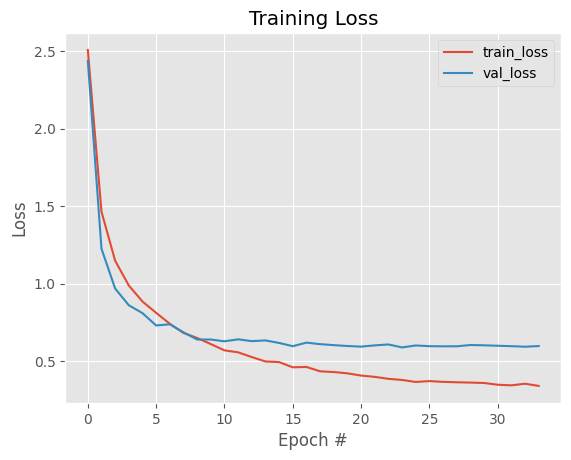

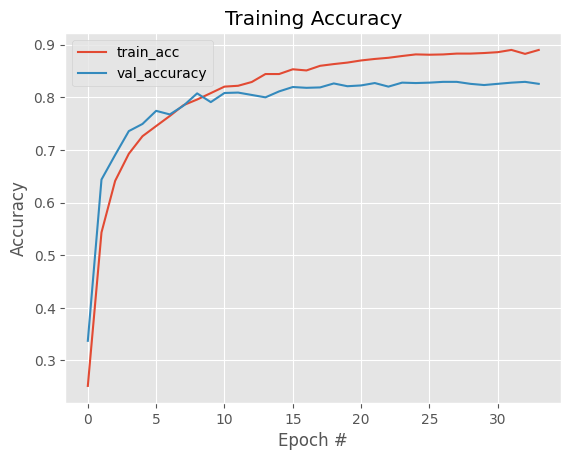

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.95      0.89      0.92        62
        down       0.92      0.76      0.83        62
       eight       0.95      0.90      0.93        62
        five       0.88      0.82      0.85        62
      follow       0.62      0.71      0.66        62
     forward       0.75      0.77      0.76        62
        four       0.86      0.81      0.83        62
          go       0.74      0.87      0.80        62
       learn       0.86      0.82      0.84        62
        left       0.87      0.87      0.87        62
        nine       0.84      0.92      0.88        62
          no       0.79      0.85      0.82        62
         off       0.76      0.77      0.77        62
          on       0.89      0.81      0.85        62
         one       0.88      0.84      0.86        62
       right       0.90      0.85      0.88        62
       seven       0.83      0.92      0.87       

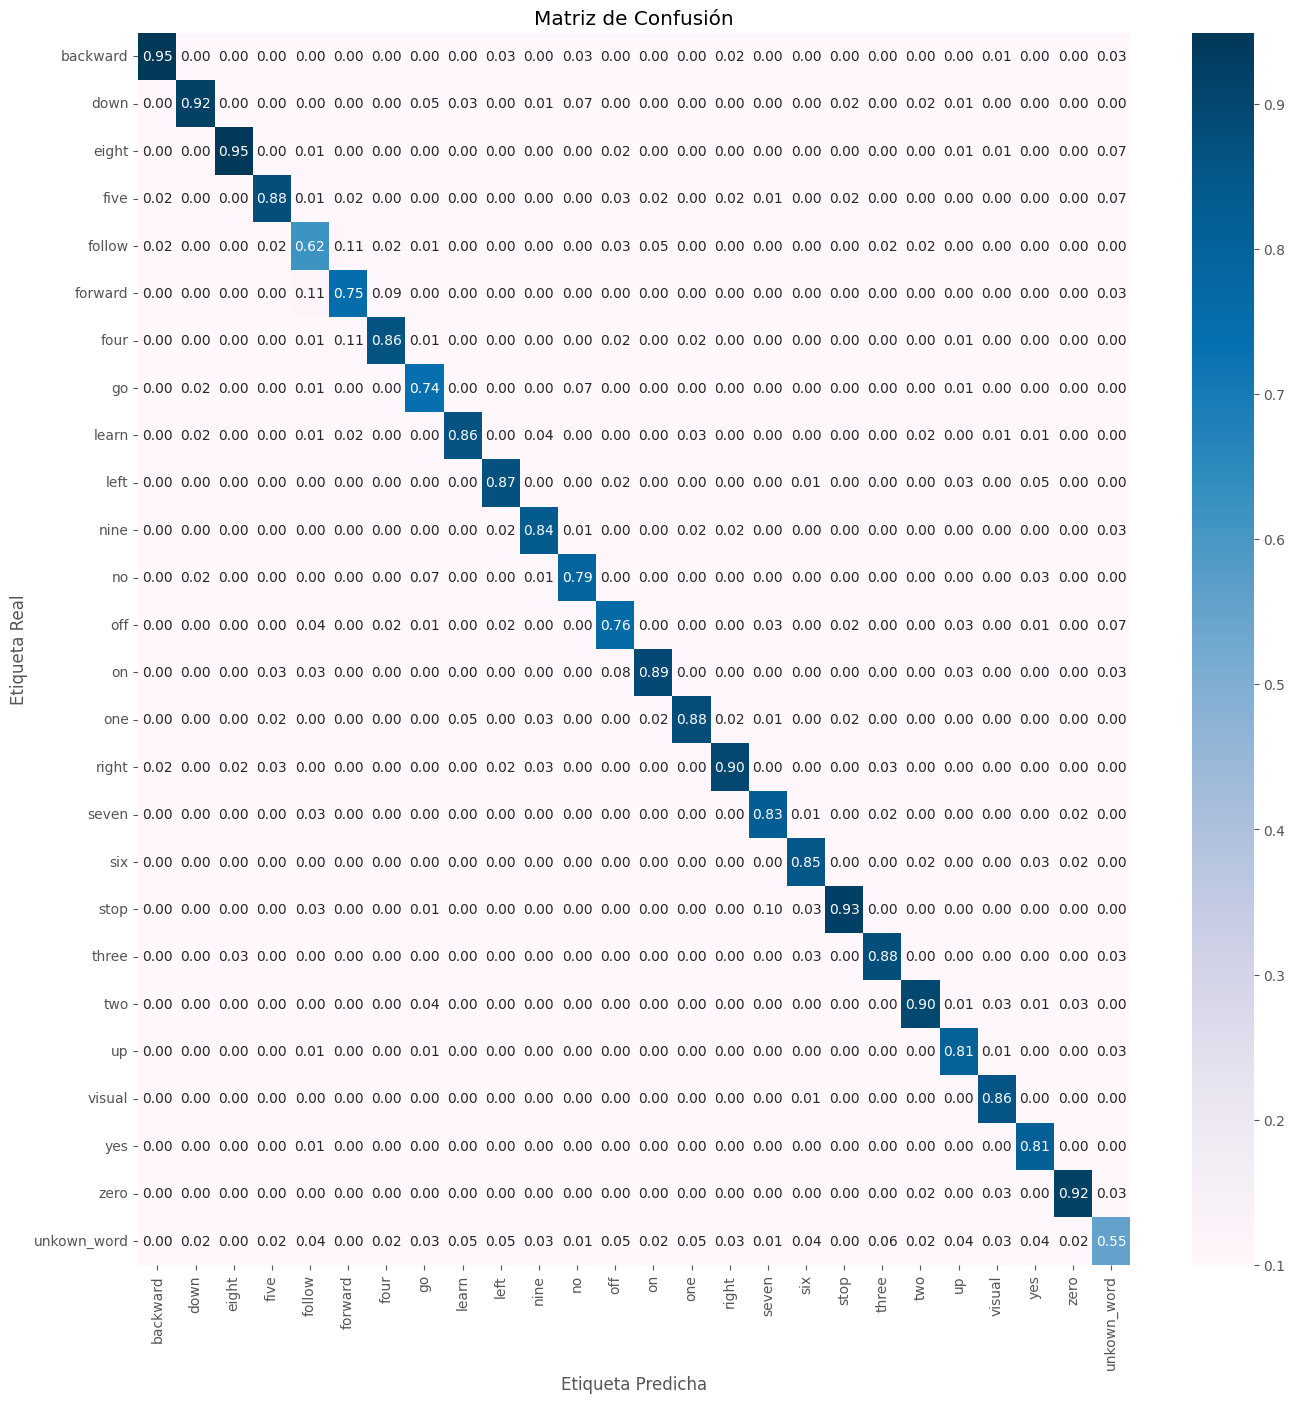

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_0_08, h_exp_a_cnn_mfcc_0_08, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_mfcc_0_09

In [ ]:
exp_a_cnn_mfcc_0_09 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Tercera capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    Flatten(),  # Aplanar para pasar a capas densas

    # Capa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.1),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_mfcc_0_09.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_0_09.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_0_09.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_mfcc_0_09 = exp_a_cnn_mfcc_0_09.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1803 - loss: 2.8725
Epoch 1: val_loss improved from inf to 2.49629, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.1806 - loss: 2.8713 - val_accuracy: 0.2845 - val_loss: 2.4963 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5460 - loss: 1.4753
Epoch 2: val_loss improved from 2.49629 to 1.14558, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5461 - loss: 1.4750 - val_accuracy: 0.6755 - val_loss: 1.1456 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6618 - loss: 1.0997
Epoch 3: val_loss improved from 1.14558 to 0.96890, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6619 - loss: 1.0994 - val_accuracy: 0.7200 - val_loss: 0.9689 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7151 - loss: 0.9302
Epoch 4: val_loss improved from 0.96890 to 0.83505, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7152 - loss: 0.9298 - val_accuracy: 0.7374 - val_loss: 0.8351 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7478 - loss: 0.8197
Epoch 5: val_loss improved from 0.83505 to 0.78461, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7478 - loss: 0.8191 - val_accuracy: 0.7547 - val_loss: 0.7846 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7759 - loss: 0.7218
Epoch 6: val_loss improved from 0.78461 to 0.69148, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7759 - loss: 0.7215 - val_accuracy: 0.7796 - val_loss: 0.6915 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7900 - loss: 0.6783
Epoch 7: val_loss did not improve from 0.69148
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7900 - loss: 0.6779 - val_accuracy: 0.7653 - val_loss: 0.7457 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8049 - loss: 0.6163
Epoch 8: val_loss improved from 0.69148 to 0.64175, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8049 - loss: 0.6162 - val_accuracy: 0.8023 - val_loss: 0.6418 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8176 - loss: 0.5697
Epoch 9: val_loss improved from 0.64175 to 0.63104, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8176 - loss: 0.5697 - val_accuracy: 0.8015 - val_loss: 0.6310 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8259 - loss: 0.5358
Epoch 10: val_loss did not improve from 0.63104
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8260 - loss: 0.5357 - val_accuracy: 0.7955 - val_loss: 0.6477 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8365 - loss: 0.5056
Epoch 11: val_loss improved from 0.63104 to 0.57496, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8365 - loss: 0.5054 - val_accuracy: 0.8196 - val_loss: 0.5750 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8431 - loss: 0.4745
Epoch 12: val_loss did not improve from 0.57496
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8431 - loss: 0.4745 - val_accuracy: 0.8189 - val_loss: 0.5796 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8580 - loss: 0.4472
Epoch 13: val_loss did not improve from 0.57496
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8580 - loss: 0.4472 - val_accuracy: 0.8158 - val_loss: 0.5775 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8567 - loss: 0.4441 - val_accuracy: 0.8242 - val_loss: 0.5594 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8646 - loss: 0.4235
Epoch 15: val_loss improved from 0.55944 to 0.53911, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8646 - loss: 0.4234 - val_accuracy: 0.8370 - val_loss: 0.5391 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8657 - loss: 0.4046
Epoch 16: val_loss did not improve from 0.53911
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8657 - loss: 0.4046 - val_accuracy: 0.8302 - val_loss: 0.5468 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8785 - loss: 0.3825
Epoch 17: val_loss did not improve from 0.53911
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8785 - loss: 0.3824 - val_accuracy: 0.8302 - val_loss: 0.5566 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8851 - loss: 0.3622 - val_accuracy: 0.8377 - val_loss: 0.5317 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8849 - loss: 0.3552
Epoch 20: val_loss improved from 0.53169 to 0.53013, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8849 - loss: 0.3552 - val_accuracy: 0.8385 - val_loss: 0.5301 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8845 - loss: 0.3443
Epoch 21: val_loss did not improve from 0.53013
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8846 - loss: 0.3442 - val_accuracy: 0.8377 - val_loss: 0.5361 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8882 - loss: 0.3440
Epoch 22: val_loss improved from 0.53013 to 0.52782, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8882 - loss: 0.3439 - val_accuracy: 0.8340 - val_loss: 0.5278 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8950 - loss: 0.3341
Epoch 23: val_loss did not improve from 0.52782
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8950 - loss: 0.3340 - val_accuracy: 0.8279 - val_loss: 0.5372 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8931 - loss: 0.3248
Epoch 24: val_loss did not improve from 0.52782
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8931 - loss: 0.3248 - val_accuracy: 0.8377 - val_loss: 0.5314 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8953 - loss: 0.3163 - val_accuracy: 0.8377 - val_loss: 0.5237 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8996 - loss: 0.3142
Epoch 26: val_loss improved from 0.52373 to 0.52092, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_0_09.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8996 - loss: 0.3142 - val_accuracy: 0.8317 - val_loss: 0.5209 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8969 - loss: 0.3151
Epoch 27: val_loss did not improve from 0.52092
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8969 - loss: 0.3149 - val_accuracy: 0.8317 - val_loss: 0.5284 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9013 - loss: 0.3049
Epoch 28: val_loss did not improve from 0.52092
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9013 - loss: 0.3049 - val_accuracy: 0.8317 - val_loss: 0.5292 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9106 - loss: 0.2827 - val_accuracy: 0.8347 - val_loss: 0.5192 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9088 - loss: 0.2823
Epoch 36: val_loss did not improve from 0.51915
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9089 - loss: 0.2822 - val_accuracy: 0.8332 - val_loss: 0.5227 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9128 - loss: 0.2804
Epoch 37: val_loss did not improve from 0.51915
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9128 - loss: 0.2804 - val_accuracy: 0.8325 - val_loss: 0.5242 - learning_rate: 2.2528e-05

Epoch 38: LearningRateScheduler setting learning rate to 2.0275559590445276e-05.
Epoch 38/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

In [ ]:
exp_a_cnn_mfcc_0_09.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 23, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 23, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 11, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 9, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 9, 13, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 4, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 2, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 2, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 1, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 317,424 (1.21 MB)

 Trainable params: 105,658 (412.73 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 211,318 (825.46 KB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


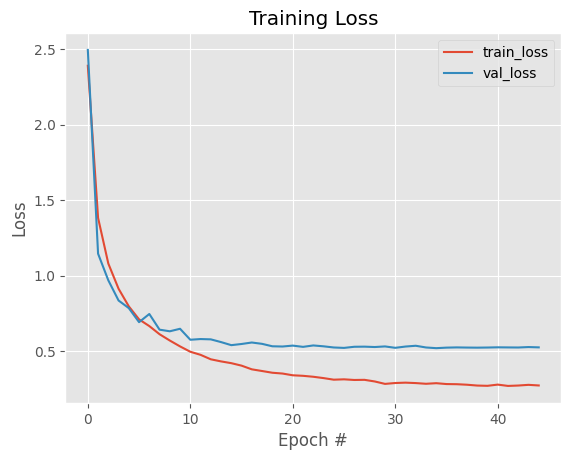

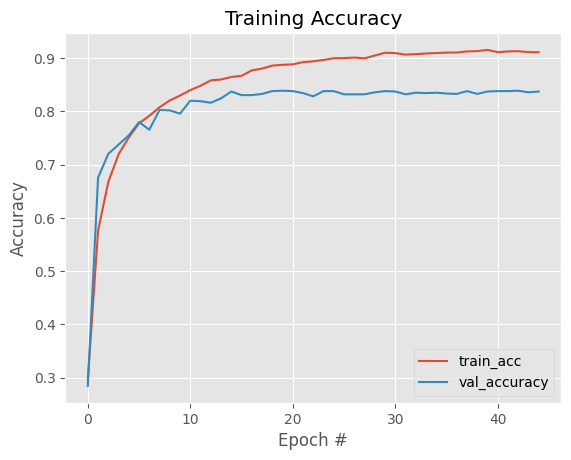

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.91      0.95      0.93        62
        down       0.87      0.74      0.80        62
       eight       0.91      0.94      0.92        62
        five       0.84      0.84      0.84        62
      follow       0.70      0.79      0.74        62
     forward       0.75      0.76      0.75        62
        four       0.77      0.79      0.78        62
          go       0.70      0.79      0.74        62
       learn       0.80      0.77      0.79        62
        left       0.93      0.84      0.88        62
        nine       0.93      0.90      0.92        62
          no       0.78      0.87      0.82        62
         off       0.94      0.81      0.87        62
          on       0.78      0.82      0.80        62
         one       0.90      0.87      0.89        62
       right       0.95      0.89      0.92        62
       seven       0.91      0.95      0.93       

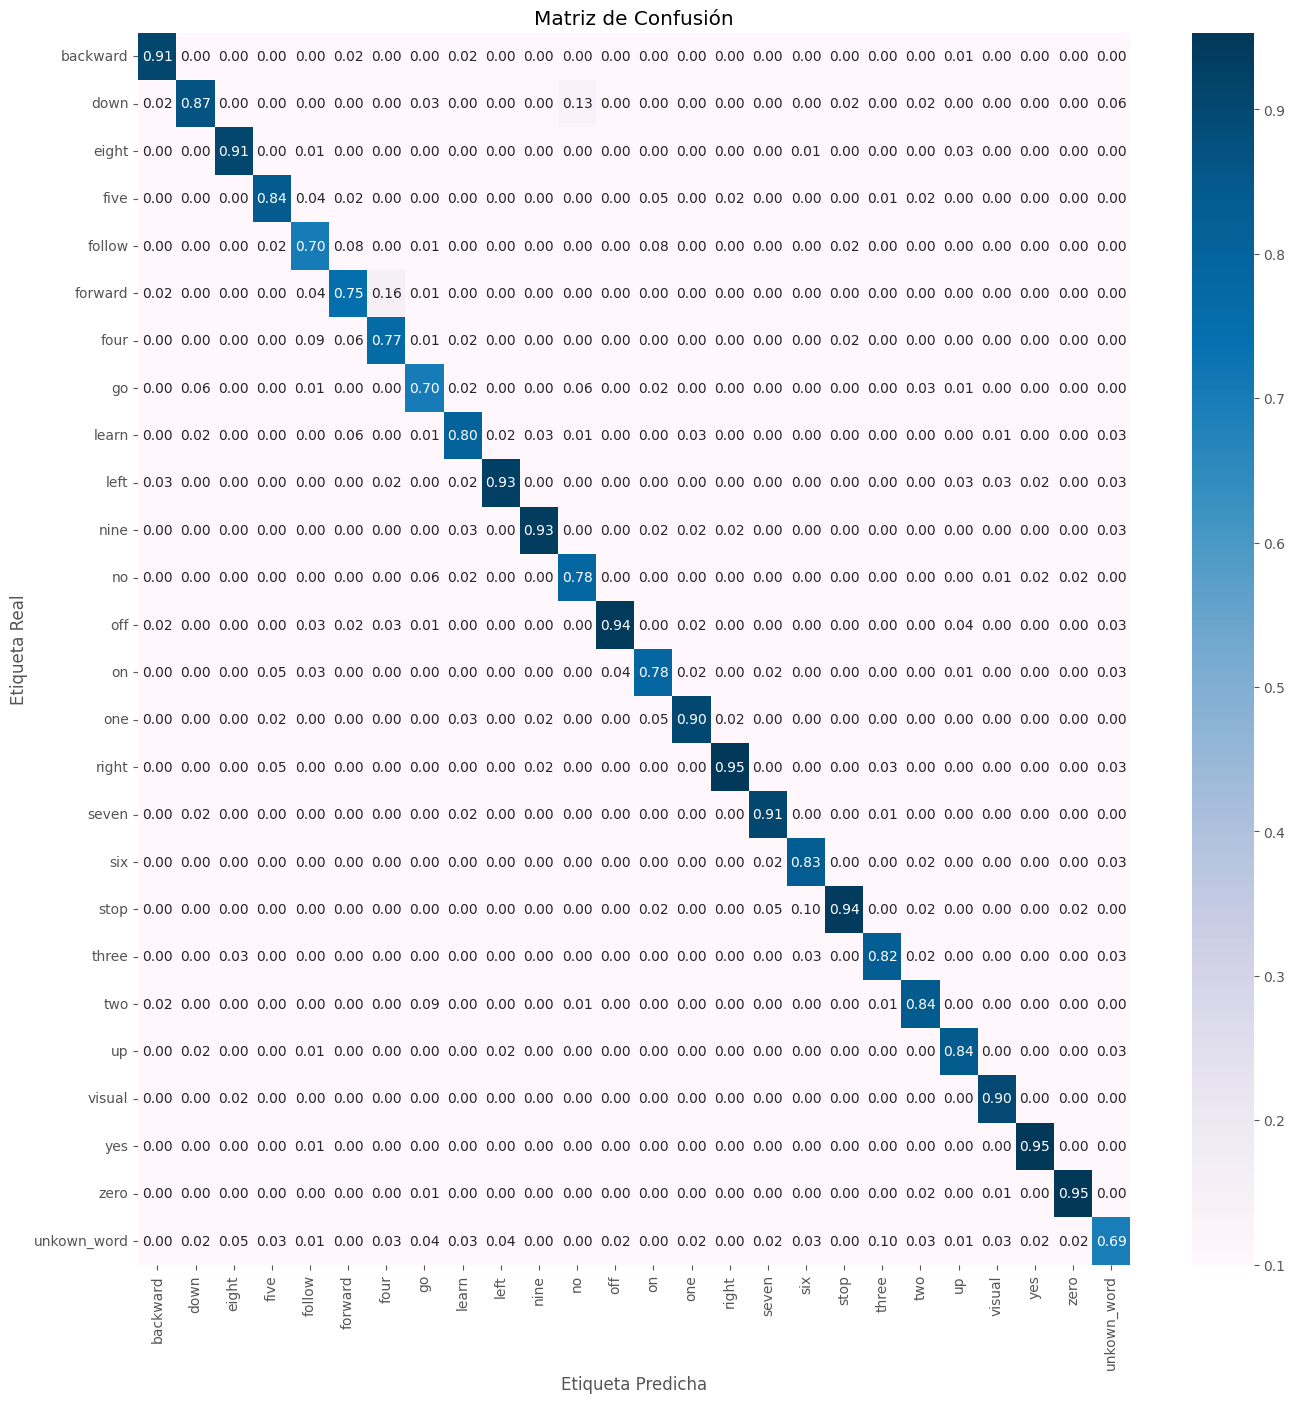

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_0_09, h_exp_a_cnn_mfcc_0_09, x_test, y_test, batch_size, classes)
mis.show_all()